# Ministry-Based Topic Analysis of Singapore Budget Speeches

This notebook analyzes the distribution of ministry-related topics across Singapore budget speeches from 1960 to 2025. Topics are mapped to current Singapore government ministries to understand how budget priorities have evolved across different policy areas.

## Setup and Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import sys
from collections import Counter

# Add extractor to path for importing speech_links
sys.path.append(str(Path.cwd().parent / 'extractor'))
from speech_links import budget_speech_links

# Configure plotting style
sns.set_style('white')
sns.despine()
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = False

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


<Figure size 640x480 with 0 Axes>

## Load Budget Speech Data

In [2]:
# Load all parquet files
output_processor_path = Path.cwd().parent / 'output_processor'
parquet_files = sorted(output_processor_path.glob('*.parquet'))

print(f"Found {len(parquet_files)} parquet files")

# Read and combine all parquet files
dfs = []
for file in parquet_files:
    df = pd.read_parquet(file)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Data loaded successfully!")
print(f"  Total speeches: {df_all['year'].nunique()} years")
print(f"  Total sentences: {len(df_all):,}")
print(f"  Year range: {df_all['year'].min()} - {df_all['year'].max()}")
print(f"  Columns: {df_all.columns.tolist()}")

df_all.head()

Found 66 parquet files

✓ Data loaded successfully!
  Total speeches: 66 years
  Total sentences: 39,707
  Year range: 1960 - 2025
  Columns: ['sentence_id', 'year', 'section_title', 'sentence_order', 'sentence_text', 'word_count', 'syllable_count', 'char_count']


,sentence_id,year,section_title,sentence_order,sentence_text,word_count,syllable_count,char_count
0,1960_0,1960,None,0,ANNUAL BUDGET STATEMENT,3,6,23
1,1960_1,1960,None,1,Dr Goh Keng Swee (Minister for Finance),7,10,39
2,1960_2,1960,None,2,The Minister for Finance (Dr Goh Keng Swee): M...,15,19,76
3,1960_3,1960,None,3,That the Assembly approves the financial polic...,14,20,84
4,1960_4,1960,None,4,"In ordinary times, the presentation of the bud...",19,30,111


## Add Minister Information

In [3]:
# Create a dataframe with minister information
minister_info = []
for year, info in budget_speech_links.items():
    minister_info.append({
        'year': year,
        'minister': info['minister'],
        'date': info['date']
    })

df_ministers = pd.DataFrame(minister_info)

# Merge with the main dataframe
df_all = df_all.merge(df_ministers, on='year', how='left')

print(f"✓ Minister information added")
print(f"  Ministers in dataset:")
for minister in df_all['minister'].unique():
    if pd.notna(minister):
        count = df_all[df_all['minister'] == minister]['year'].nunique()
        print(f"    - {minister}: {count} speeches")

✓ Minister information added
  Ministers in dataset:
    - Goh Keng Swee: 9 speeches
    - Lim Kim San: 2 speeches
    - Hon Sui Sen: 8 speeches
    - Goh Chok Tong: 3 speeches
    - Dr Tony Tan Keng Yam: 4 speeches
    - Dr Richard Hu Tsu Tau: 16 speeches
    - Lee Hsien Loong: 5 speeches
    - Tharman Shanmugaratnam: 9 speeches
    - Heng Swee Keat: 6 speeches
    - Lawrence Wong: 4 speeches


## Define Ministry Topics

Map sentences to current Singapore government ministries based on keyword matching.

In [4]:
MINISTRY_TOPICS = {
    'communications_information': {
        'keywords': [
            '5g', 'broadband', 'broadcasting', 'communications', 'cyber',
            'digital', 'imda', 'infocomm', 'information', 'internet', 'media',
            'technology', 'telecommunications'
        ],
        'label': 'Communications & Information',
        'colour': '#4361EE'
    },
    'culture_community_youth': {
        'keywords': [
            'arts', 'community', 'community development', 'community services', 'culture',
            'heritage', 'library', 'mccy', 'museum', 'racial harmony',
            'recreation', 'sport', 'sports', 'youth'
        ],
        'label': 'Culture, Community & Youth',
        'colour': '#E63946'
    },
    'defence': {
        'keywords': [
            'against', 'air force', 'army', 'conditions',
            'defence', 'defense', 'expansion', 'loans',
            'military', 'mindef', 'national service', 'navy',
            'ns', 'rsaf', 'rsn', 'saf', 'safti',
            'security'
        ],
        'label': 'Defence',
        'colour': '#5F0F40'
    },
    'education': {
        'keywords': [
            'college', 'curriculum', 'education',
            'ite', 'items', 'learning', 'moe',
            'ntu', 'nus', 'polytechnic', 'preschool', 'primary',
            'school', 'schools', 'secondary', 'skillsfuture', 'smu',
            'states', 'student', 'students', 'teacher', 'tertiary',
            'universities', 'university'
        ],
        'label': 'Education',
        'colour': '#C73E1D'
    },
    'finance': {
        'keywords': [
            'budget', 'corporate', 'corporate tax', 'customs', 'debt',
            'deficit', 'duties', 'duty', 'estimated', 'excise',
            'exemption', 'fiscal', 'gst', 'income', 'income tax',
            'iras', 'personal', 'personal income', 'personal income tax', 'property',
            'property tax', 'rates', 'revenue', 'revenues', 'stamp',
            'stamp duty', 'surplus', 'tax', 'tax changes', 'tax exemption',
            'tax rate', 'tax rates', 'taxes', 'treasury', 'financial policy'
        ],
        'label': 'Finance',
        'colour': '#2E86AB'
    },
    'foreign_affairs': {
        'keywords': [
            'ambassador', 'asean', 'asean economic', 'bilateral', 'diplomatic',
            'economic cooperation', 'embassy', 'foreign', 'foreign exchange', 'international',
            'mfa', 'overseas', 'overseas markets', 'relations', 'treaty'
        ],
        'label': 'Foreign Affairs',
        'colour': '#0077B6'
    },
    'health': {
        'keywords': [
            'careshield', 'clinic', 'disease', 'doctor',
            'eldercare', 'eldershield', 'health', 'healthcare', 'healthcare needs',
            'healthy', 'hospital', 'hospitals', 'medical', 'medisave',
            'medisave top', 'medishield', 'medishield life', 'moh', 'nurse',
            'patient', 'patients', 'polyclinic', 'polyclinics'
        ],
        'label': 'Health',
        'colour': '#6A994E'
    },
    'home_affairs': {
        'keywords': [
            'civil defence', 'crime',
            'emergency', 'fire', 'home affairs', 'ica',
            'immigration', 'law enforcement', 'police',
            'safety', 'scdf'
        ],
        'label': 'Home Affairs',
        'colour': '#9B2226'
    },
    'law': {
        'keywords': [
            'attorney general', 'court', 'judge', 'judiciary', 'justice',
            'law', 'legal', 'legislation', 'minlaw', 'regulation',
            'statute'
        ],
        'label': 'Law',
        'colour': '#06668D'
    },
    'manpower': {
        'keywords': [
            'cpf', 'cpf contribution', 'employers', 'employment', 'foreign workers',
            'jobs', 'labor', 'labour', 'low wage', 'manpower',
            'ntuc', 'older workers', 'progressive wage', 'retirement', 'salary',
            'skilled', 'skilled workers', 'skills', 'training', 'unemployment',
            'wage', 'wage workers', 'wages', 'workers',
            'workfare', 'workforce'
        ],
        'label': 'Manpower',
        'colour': '#F18F01'
    },
    'national_development': {
        'keywords': [
            'bca', 'bto', 'building', 'construction', 'estate',
            'estate duty', 'estates', 'flat', 'flats', 'hdb',
            'hdb flats', 'housing', 'inflation', 'inflationary', 'living room',
            'planning', 'property', 'public housing', 'resale', 'room',
            'room flats', 'room hdb', 'room hdb flats', 'town', 'ura',
            'urban'
        ],
        'label': 'National Development',
        'colour': '#BC4749'
    },
    'social_family_development': {
        'keywords': [
            'aged', 'assistance', 'children', 'comcare', 'compact',
            'elderly', 'family', 'family development', 'low income', 'msf',
            'social', 'social compact', 'social support', 'subsidy', 'vulnerable',
            'welfare'
        ],
        'label': 'Social & Family Development',
        'colour': '#F77F00'
    },
    'sustainability_environment': {
        'keywords': [
            'carbon', 'carbon emissions', 'carbon tax', 'climate', 'climate change',
            'emission', 'emissions', 'energy', 'environment', 'green',
            'nea', 'net zero', 'pollution', 'pub', 'recycling',
            'renewable', 'sustainability', 'waste', 'water'
        ],
        'label': 'Sustainability & Environment',
        'colour': '#588157'
    },
    'trade_industry': {
        'keywords': [
            'assessment', 'business', 'businesses', 'commerce', 'edb',
            'enterprise', 'enterprises', 'export', 'exports', 'fdi',
            'import', 'important', 'imports', 'industrial', 'industry',
            'innovation', 'investment', 'investments', 'manufacturing', 'manufacturing sector',
            'productivity', 'sme', 'smes', 'startup', 'trade', 'economic', 'economy',
            'economic development', 'global economy'
        ],
        'label': 'Trade & Industry',
        'colour': '#A23B72'
    },
    'transport': {
        'keywords': [
            'airport', 'bus', 'car', 'cars', 'changi airport',
            'coe', 'erp', 'lrt', 'lta', 'maritime',
            'mrt', 'opportunities', 'port', 'public transport', 'road',
            'roads', 'shipping', 'smrt', 'taxi', 'taxis',
            'traffic', 'train', 'transport'
        ],
        'label': 'Transport',
        'colour': '#386641'
    },
}

print(f"Defined {len(MINISTRY_TOPICS)} ministry topic categories:")
for key, info in MINISTRY_TOPICS.items():
    print(f"  • {info['label']}: {len(info['keywords'])} keywords")

Defined 15 ministry topic categories:
  • Communications & Information: 13 keywords
  • Culture, Community & Youth: 14 keywords
  • Defence: 18 keywords
  • Education: 24 keywords
  • Finance: 35 keywords
  • Foreign Affairs: 15 keywords
  • Health: 23 keywords
  • Home Affairs: 11 keywords
  • Law: 11 keywords
  • Manpower: 26 keywords
  • National Development: 26 keywords
  • Social & Family Development: 16 keywords
  • Sustainability & Environment: 19 keywords
  • Trade & Industry: 29 keywords
  • Transport: 23 keywords


## Classify Sentences to Ministry Topics

Using weighted keyword matching approach. Sentences with no clear ministry match are labeled as 'general'.

In [5]:
def classify_sentence_to_ministry(text):
    """
    Classify a sentence to the most relevant ministry based on keyword matching.
    Uses weighted scoring where multi-word keywords have higher specificity.
    
    Returns: (ministry_key, confidence_score)
    """
    text_lower = text.lower()
    scores = {}
    
    for ministry, info in MINISTRY_TOPICS.items():
        score = 0
        matches = []
        
        for keyword in info['keywords']:
            if keyword in text_lower:
                # Multi-word keywords are more specific, give them higher weight
                word_count = len(keyword.split())
                weight = word_count if word_count > 1 else 1
                score += weight
                matches.append(keyword)
        
        scores[ministry] = score
    
    # Get best match
    max_score = max(scores.values())
    
    if max_score == 0:
        return 'general', 0
    
    best_ministry = max(scores, key=scores.get)
    return best_ministry, max_score

# Apply classification to all sentences
print("Classifying sentences to ministry topics...")
print("This may take a few minutes for 40,000+ sentences...\n")

classification_results = df_all['sentence_text'].apply(classify_sentence_to_ministry)
df_all['ministry_topic'] = classification_results.apply(lambda x: x[0])
df_all['topic_confidence'] = classification_results.apply(lambda x: x[1])

print("✓ Classification complete!\n")

# Show classification statistics
topic_counts = df_all['ministry_topic'].value_counts()
print("Sentence distribution across ministry topics:")
print("="*60)
for topic, count in topic_counts.items():
    pct = (count / len(df_all)) * 100
    label = MINISTRY_TOPICS[topic]['label'] if topic != 'general' else 'General/Other'
    print(f"  {label:35s}: {count:6,} ({pct:5.1f}%)")

print(f"\nAverage confidence score: {df_all['topic_confidence'].mean():.2f}")
print(f"Sentences with clear ministry topic: {(df_all['ministry_topic'] != 'general').sum():,} ({(df_all['ministry_topic'] != 'general').sum() / len(df_all) * 100:.1f}%)")

Classifying sentences to ministry topics...
This may take a few minutes for 40,000+ sentences...

✓ Classification complete!

Sentence distribution across ministry topics:
  General/Other                      :  8,428 ( 21.2%)
  Defence                            :  7,362 ( 18.5%)
  Finance                            :  6,127 ( 15.4%)
  Trade & Industry                   :  4,906 ( 12.4%)
  Manpower                           :  2,709 (  6.8%)
  Education                          :  2,082 (  5.2%)
  Transport                          :  1,712 (  4.3%)
  National Development               :  1,563 (  3.9%)
  Health                             :    849 (  2.1%)
  Sustainability & Environment       :    801 (  2.0%)
  Social & Family Development        :    673 (  1.7%)
  Home Affairs                       :    657 (  1.7%)
  Foreign Affairs                    :    632 (  1.6%)
  Communications & Information       :    627 (  1.6%)
  Culture, Community & Youth         :    519 (  1.3%)
  L

## Sample Classified Sentences

Let's verify the classification by examining sample sentences from each ministry topic.

In [6]:
# Show sample sentences for each ministry (excluding 'general')
print("Sample classified sentences:\n")
print("="*100)

for ministry in sorted(MINISTRY_TOPICS.keys()):
    ministry_sentences = df_all[df_all['ministry_topic'] == ministry]
    
    if len(ministry_sentences) > 0:
        # Get a high-confidence example
        sample = ministry_sentences.nlargest(1, 'topic_confidence').iloc[0]
        
        print(f"\n{MINISTRY_TOPICS[ministry]['label']}:")
        print(f"  Year: {sample['year']}")
        print(f"  Confidence: {sample['topic_confidence']:.1f}")
        print(f"  Text: {sample['sentence_text'][:150]}..." if len(sample['sentence_text']) > 150 else f"  Text: {sample['sentence_text']}")
        print("-"*100)

Sample classified sentences:


Communications & Information:
  Year: 1998
  Confidence: 4.0
  Text: The media and communications sectors, including advertising, information technology, and content creation will also benefit from this development.
----------------------------------------------------------------------------------------------------

Culture, Community & Youth:
  Year: 1995
  Confidence: 7.0
  Text: To meet expectations for a better quality of life, and to develop a more robust, well-balanced and cohesive society, more funds will also be made avai...
----------------------------------------------------------------------------------------------------

Defence:
  Year: 2019
  Confidence: 5.0
  Text: Last year, the Ministry of Defence (MINDEF) launched the Cyber National Servicemen scheme, training National Servicemen(NSmen)with the Singapore Insti...
----------------------------------------------------------------------------------------------------

Education:
  Year: 2009


## Analysis of Unclassified Sentences

Let's examine sentences classified as 'general' to identify potential keywords that could improve our classification.

In [7]:
import re
from collections import Counter

# Get sentences classified as 'general'
general_sentences = df_all[df_all['ministry_topic'] == 'general']['sentence_text']

print(f"Analyzing {len(general_sentences):,} sentences classified as 'general'")
print(f"This represents {len(general_sentences) / len(df_all) * 100:.1f}% of all sentences\n")

# Extract all words (excluding common stop words)
stop_words = set([
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with',
    'by', 'from', 'as', 'is', 'was', 'are', 'were', 'be', 'been', 'being', 'have', 'has',
    'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can',
    'this', 'that', 'these', 'those', 'i', 'we', 'you', 'he', 'she', 'it', 'they', 'them',
    'their', 'what', 'which', 'who', 'when', 'where', 'why', 'how', 'all', 'each', 'every',
    'both', 'few', 'more', 'most', 'other', 'some', 'such', 'than', 'too', 'very', 'so',
    'just', 'now', 'only', 'also', 'its', 'my', 'our', 'your', 'his', 'her', 'not', 'no',
    'out', 'up', 'if', 'about', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'between', 'under', 'again', 'further', 'then', 'once', 'here', 'there',
    'mr', 'shall', 'singapore', 'year', 'years', 'per', 'cent', 'time', 'make', 'made'
])

# Extract words
all_words = []
for sentence in general_sentences:
    # Convert to lowercase and extract words
    words = re.findall(r'\b[a-z]+\b', sentence.lower())
    # Filter out stop words and very short words
    words = [w for w in words if w not in stop_words and len(w) > 3]
    all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)

# Show top 50 most common words
print("="*80)
print("TOP 50 MOST COMMON WORDS IN UNCLASSIFIED SENTENCES:")
print("="*80)
print(f"\n{'Rank':<6} {'Word':<25} {'Count':<10} {'% of General Sentences':<25}")
print("-"*80)

for rank, (word, count) in enumerate(word_counts.most_common(50), 1):
    pct = (count / len(general_sentences)) * 100
    print(f"{rank:<6} {word:<25} {count:<10,} {pct:<25.1f}%")

# Also extract bigrams (two-word phrases)
print("\n\n" + "="*80)
print("TOP 30 MOST COMMON TWO-WORD PHRASES:")
print("="*80)

bigrams = []
for sentence in general_sentences:
    words = re.findall(r'\b[a-z]+\b', sentence.lower())
    # Create bigrams
    for i in range(len(words) - 1):
        phrase = f"{words[i]} {words[i+1]}"
        # Skip if either word is a stop word or too short
        if words[i] not in stop_words and words[i+1] not in stop_words:
            if len(words[i]) > 3 and len(words[i+1]) > 3:
                bigrams.append(phrase)

bigram_counts = Counter(bigrams)

print(f"\n{'Rank':<6} {'Phrase':<35} {'Count':<10} {'% of General Sentences':<25}")
print("-"*80)

for rank, (phrase, count) in enumerate(bigram_counts.most_common(30), 1):
    pct = (count / len(general_sentences)) * 100
    print(f"{rank:<6} {phrase:<35} {count:<10,} {pct:<25.1f}%")

# Show a few example sentences with the most common unclassified words
print("\n\n" + "="*80)
print("SAMPLE SENTENCES WITH TOP UNCLASSIFIED KEYWORDS:")
print("="*80)

top_words = [word for word, _ in word_counts.most_common(5)]
for word in top_words:
    matching = general_sentences[general_sentences.str.contains(word, case=False, na=False)]
    if len(matching) > 0:
        print(f"\n[{word.upper()}] Example:")
        print(f"  {matching.iloc[0][:200]}..." if len(matching.iloc[0]) > 200 else f"  {matching.iloc[0]}")

Analyzing 8,428 sentences classified as 'general'
This represents 21.2% of all sentences

TOP 50 MOST COMMON WORDS IN UNCLASSIFIED SENTENCES:

Rank   Word                      Count      % of General Sentences   
--------------------------------------------------------------------------------
1      million                   741        8.8                      %
2      government                548        6.5                      %
3      expenditure               368        4.4                      %
4      growth                    335        4.0                      %
5      over                      310        3.7                      %
6      development               295        3.5                      %
7      increase                  290        3.4                      %
8      billion                   241        2.9                      %
9      speaker                   236        2.8                      %
10     must                      232        2.8                    

## Visualization 1: Ministry Topic Distribution Over Time

Stacked area chart showing how the focus on different ministries has evolved.

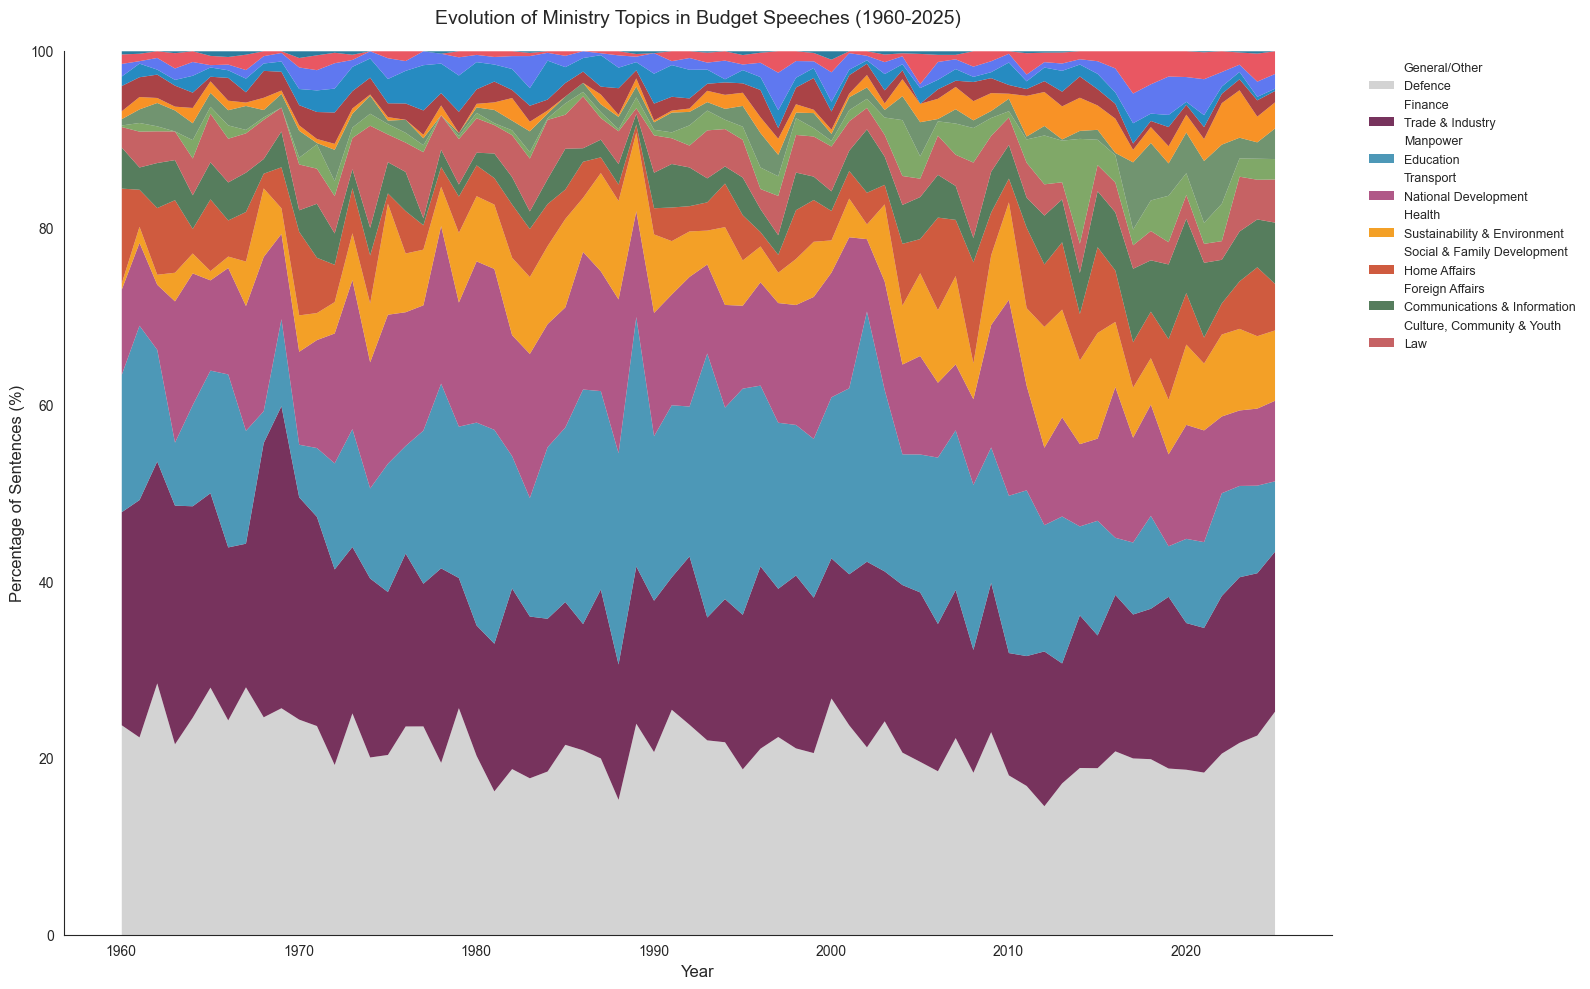


Key observations:
  - Area sizes show relative prominence of each ministry topic
  - Changes in area sizes indicate shifting budget priorities


In [8]:
# Calculate ministry distribution by year
ministry_by_year = df_all.groupby(['year', 'ministry_topic']).size().unstack(fill_value=0)

# Convert to percentages
ministry_pct = ministry_by_year.div(ministry_by_year.sum(axis=1), axis=0) * 100

# Reorder columns by total mentions (most to least)
col_order = ministry_by_year.sum().sort_values(ascending=False).index
ministry_pct = ministry_pct[col_order]

# Create colour map
colour_map = {ministry: MINISTRY_TOPICS[ministry]['colour'] 
             for ministry in MINISTRY_TOPICS.keys() if ministry in ministry_pct.columns}
colour_map['general'] = '#CCCCCC'

colours = [colour_map.get(col, '#999999') for col in ministry_pct.columns]

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(16, 10))
ministry_pct.plot(kind='area', stacked=True, ax=ax, color=colours, alpha=0.85, linewidth=0)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of Sentences (%)', fontsize=12)
ax.set_title('Evolution of Ministry Topics in Budget Speeches (1960-2025)', fontsize=14, pad=20)

# Customize legend
labels = [MINISTRY_TOPICS[col]['label'] if col != 'general' else 'General/Other' 
          for col in ministry_pct.columns]
ax.legend(labels, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=9)

ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("  - Area sizes show relative prominence of each ministry topic")
print("  - Changes in area sizes indicate shifting budget priorities")

## Visualization 2: Ministry Focus by Decade

Heatmap showing which ministries dominated budget discussions in each decade.

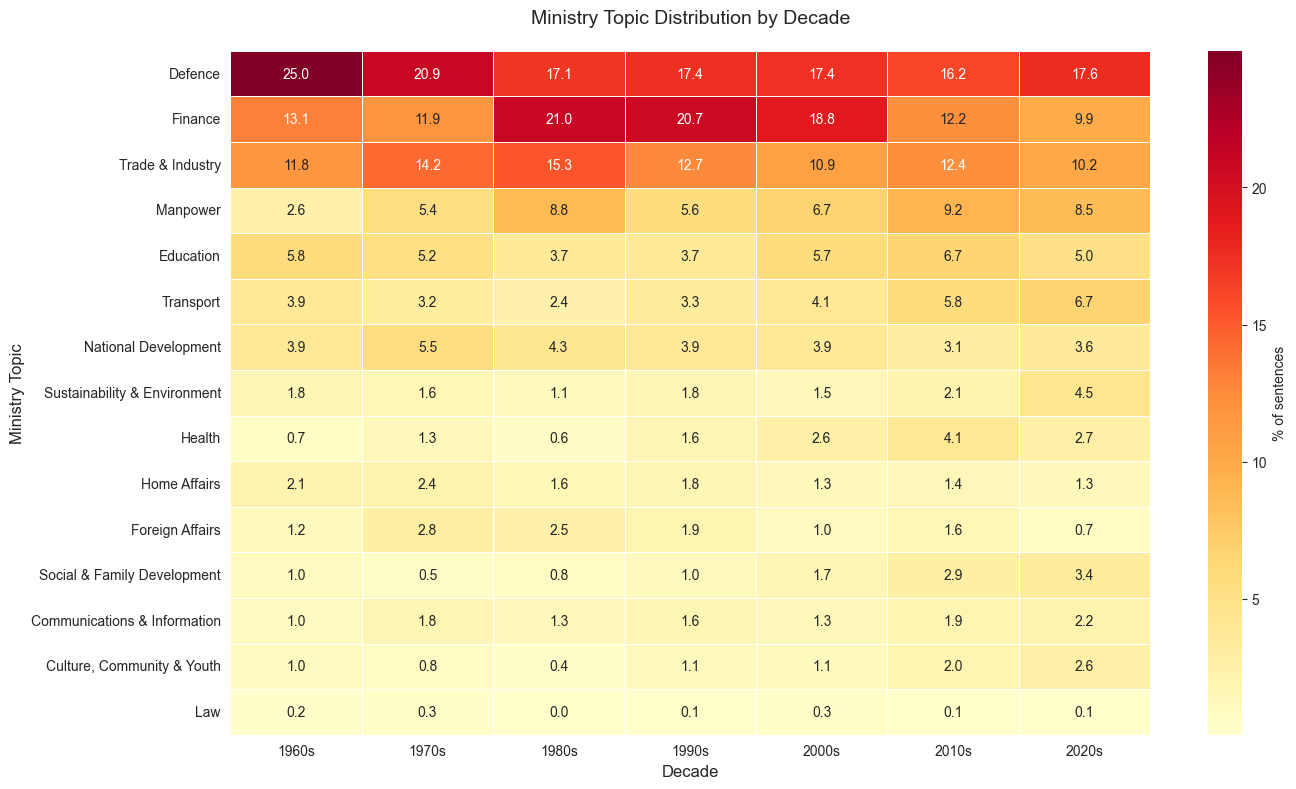


How to read this heatmap:
  - Darker colors = higher percentage of sentences
  - Each row shows how one ministry's prominence changed across decades
  - Numbers show exact percentage of sentences


In [9]:
# Create decade column
df_all['decade'] = (df_all['year'] // 10) * 10

# Calculate ministry distribution by decade
ministry_by_decade = df_all.groupby(['decade', 'ministry_topic']).size().unstack(fill_value=0)
ministry_by_decade_pct = ministry_by_decade.div(ministry_by_decade.sum(axis=1), axis=0) * 100

# Remove 'general' for clearer visualization
ministry_by_decade_pct_clean = ministry_by_decade_pct.drop('general', axis=1, errors='ignore')

# Reorder by total importance
col_order = ministry_by_decade_pct_clean.mean().sort_values(ascending=False).index
ministry_by_decade_pct_clean = ministry_by_decade_pct_clean[col_order]

# Create labels
row_labels = [f"{int(d)}s" for d in ministry_by_decade_pct_clean.index]
col_labels = [MINISTRY_TOPICS[col]['label'] for col in ministry_by_decade_pct_clean.columns]

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(ministry_by_decade_pct_clean.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': '% of sentences'}, ax=ax, linewidths=0.5,
            xticklabels=row_labels, yticklabels=col_labels)

ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Ministry Topic', fontsize=12)
ax.set_title('Ministry Topic Distribution by Decade', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print("\nHow to read this heatmap:")
print("  - Darker colors = higher percentage of sentences")
print("  - Each row shows how one ministry's prominence changed across decades")
print("  - Numbers show exact percentage of sentences")

### Understanding the Decadal Patterns

The heatmap reveals Singapore's evolving policy priorities aligned with different development phases:

**By Development Era:**
- **1960s-1970s**: Post-independence survival and rapid industrialization under founding Finance Minister Goh Keng Swee
- **1980s-1990s**: Economic restructuring and transition to services during Tony Tan and Richard Hu's tenures
- **2000s-2010s**: Knowledge economy pivot and social safety net expansion under Lee Hsien Loong and Tharman Shanmugaratnam
- **2020s**: Sustainability and digital transformation priorities under Heng Swee Keat and Lawrence Wong

**By Finance Minister Context:**
- **Goh Keng Swee (1959-1984)**: Defence prominence reflects nation-building and external threats; focus on economic survival
- **Tony Tan & Richard Hu (1983-2001)**: Finance peaks during 1980s restructuring; response to recessions and Asian Financial Crisis
- **Lee Hsien Loong (2001-2007)**: Education and Trade & Industry emphasis during post-9/11 and SARS recovery; knowledge economy transition
- **Tharman Shanmugaratnam (2007-2015)**: Social policy expansion during Global Financial Crisis; shift toward inclusive growth model with Workfare, healthcare subsidies
- **Heng Swee Keat (2015-2021)**: Manpower and Social & Family Development rise with Pioneer/Merdeka Generation packages; social compact deepening
- **Lawrence Wong (2021-present)**: Sustainability emergence with net-zero commitments; COVID-19 recovery drives health and social support spending

The patterns reflect both Singapore's evolving maturity (security → prosperity → quality of life) and ministers' responses to contemporary challenges (oil shocks, financial crises, pandemics, climate change).

In [10]:
# Analyze decadal shifts to understand Singapore's development trajectory
print("KEY OBSERVATIONS ON DECADAL PROGRESSION:")
print("="*80)

# Calculate decade-over-decade changes for top ministries
top_5_ministries = ministry_by_decade_pct_clean.mean().nlargest(5).index

for ministry in top_5_ministries:
    values = ministry_by_decade_pct_clean[ministry]
    print(f"\n{MINISTRY_TOPICS[ministry]['label']}:")
    
    # Show decadal trajectory
    print(f"  1960s: {values.iloc[0]:.1f}% → 2020s: {values.iloc[-1]:.1f}%")
    
    # Identify peak decade
    peak_decade = values.idxmax()
    print(f"  Peak: {int(peak_decade)}s ({values.max():.1f}%)")
    
    # Trend direction
    if values.iloc[-1] > values.iloc[0]:
        print(f"  Trend: ↗ Rising (+{values.iloc[-1] - values.iloc[0]:.1f} pp)")
    else:
        print(f"  Trend: ↘ Declining ({values.iloc[-1] - values.iloc[0]:.1f} pp)")

print("\n" + "="*80)
print("\nHISTORICAL CONTEXT:")
print("-"*80)

# Key development phases
phases = {
    '1960s-1970s': 'Survival & Industrialization',
    '1980s-1990s': 'Economic Restructuring & Services',
    '2000s-2010s': 'Knowledge Economy & Social Safety Nets',
    '2020s': 'Sustainability & Digital Transformation'
}

for period, theme in phases.items():
    print(f"\n{period}: {theme}")

# Analyze specific patterns
print("\n" + "="*80)
print("\nPOLICY IMPLICATIONS:")
print("-"*80)

# Defence prominence analysis
if 'defence' in ministry_by_decade_pct_clean.columns:
    defence_early = ministry_by_decade_pct_clean['defence'].iloc[:2].mean()
    defence_recent = ministry_by_decade_pct_clean['defence'].iloc[-2:].mean()
    
    print(f"\n1. Defence & Security:")
    print(f"   Early decades (1960s-70s): {defence_early:.1f}%")
    print(f"   Recent decades (2010s-20s): {defence_recent:.1f}%")
    if defence_early > defence_recent:
        print(f"   → Post-independence security concerns vs. established stability")

# Social policy analysis
social_ministries = ['health', 'social_family_development', 'education']
social_present = [m for m in social_ministries if m in ministry_by_decade_pct_clean.columns]

if social_present:
    print(f"\n2. Social Policy Expansion:")
    for ministry in social_present:
        early = ministry_by_decade_pct_clean[ministry].iloc[:2].mean()
        recent = ministry_by_decade_pct_clean[ministry].iloc[-2:].mean()
        change = recent - early
        if change > 0:
            print(f"   {MINISTRY_TOPICS[ministry]['label']}: +{change:.1f} pp")
    print(f"   → Shift from growth-first to inclusive growth model")

# Economic restructuring
if 'trade_industry' in ministry_by_decade_pct_clean.columns:
    ti_1980s = ministry_by_decade_pct_clean.loc[1980, 'trade_industry'] if 1980 in ministry_by_decade_pct_clean.index else 0
    print(f"\n3. Economic Transformation:")
    print(f"   Trade & Industry prominence reflects manufacturing → services → innovation trajectory")

# Sustainability emergence
if 'sustainability_environment' in ministry_by_decade_pct_clean.columns:
    sust_recent = ministry_by_decade_pct_clean['sustainability_environment'].iloc[-2:].mean()
    sust_early = ministry_by_decade_pct_clean['sustainability_environment'].iloc[:2].mean()
    print(f"\n4. Environmental Awareness:")
    print(f"   Early: {sust_early:.1f}% → Recent: {sust_recent:.1f}%")
    print(f"   → Climate change & net-zero commitments driving new priorities")

KEY OBSERVATIONS ON DECADAL PROGRESSION:

Defence:
  1960s: 25.0% → 2020s: 17.6%
  Peak: 1960s (25.0%)
  Trend: ↘ Declining (-7.4 pp)

Finance:
  1960s: 13.1% → 2020s: 9.9%
  Peak: 1980s (21.0%)
  Trend: ↘ Declining (-3.3 pp)

Trade & Industry:
  1960s: 11.8% → 2020s: 10.2%
  Peak: 1980s (15.3%)
  Trend: ↘ Declining (-1.6 pp)

Manpower:
  1960s: 2.6% → 2020s: 8.5%
  Peak: 2010s (9.2%)
  Trend: ↗ Rising (+6.0 pp)

Education:
  1960s: 5.8% → 2020s: 5.0%
  Peak: 2010s (6.7%)
  Trend: ↘ Declining (-0.7 pp)


HISTORICAL CONTEXT:
--------------------------------------------------------------------------------

1960s-1970s: Survival & Industrialization

1980s-1990s: Economic Restructuring & Services

2000s-2010s: Knowledge Economy & Social Safety Nets

2020s: Sustainability & Digital Transformation


POLICY IMPLICATIONS:
--------------------------------------------------------------------------------

1. Defence & Security:
   Early decades (1960s-70s): 23.0%
   Recent decades (2010s-20s): 16

## Visualization 3: Top Ministries by Year

Line chart showing the top 5 most discussed ministry topics over time.

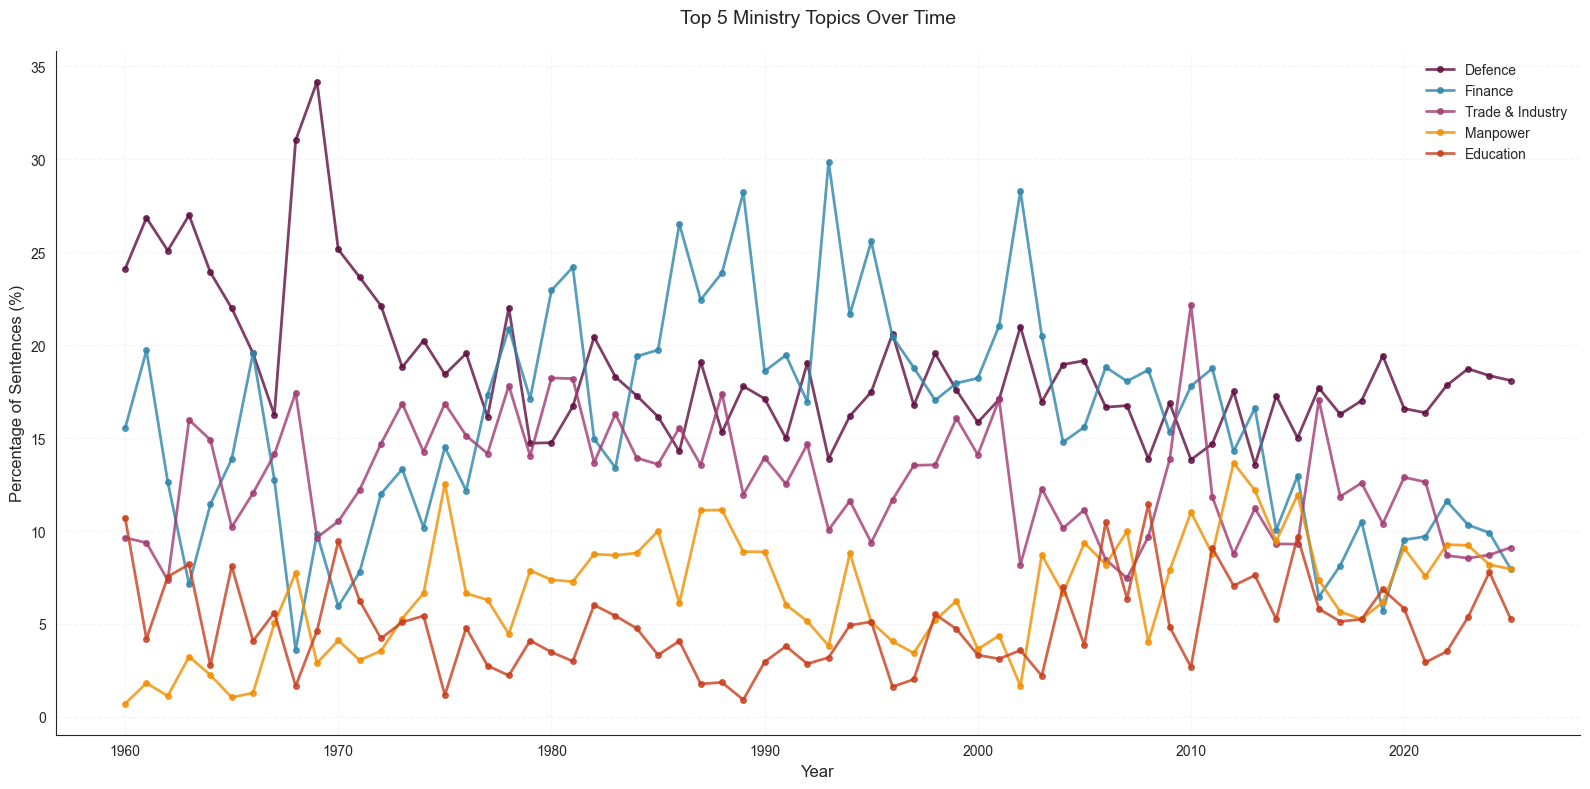


Top 5 most discussed ministries:
  1. Defence: 7,362 sentences (18.5%)
  2. Finance: 6,127 sentences (15.4%)
  3. Trade & Industry: 4,906 sentences (12.4%)
  4. Manpower: 2,709 sentences (6.8%)
  5. Education: 2,082 sentences (5.2%)


In [11]:
# Get top 5 ministries overall (excluding 'general')
top_ministries = df_all[df_all['ministry_topic'] != 'general']['ministry_topic'].value_counts().head(5).index

# Filter data for top ministries
ministry_pct_top = ministry_pct[top_ministries]

# Plot line chart
fig, ax = plt.subplots(figsize=(16, 8))

for ministry in top_ministries:
    ax.plot(ministry_pct_top.index, ministry_pct_top[ministry], 
           marker='o', linewidth=2, markersize=4, alpha=0.8,
           label=MINISTRY_TOPICS[ministry]['label'],
           color=MINISTRY_TOPICS[ministry]['colour'])

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of Sentences (%)', fontsize=12)
ax.set_title('Top 5 Ministry Topics Over Time', fontsize=14, pad=20)
ax.legend(frameon=False, fontsize=10, loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nTop 5 most discussed ministries:")
for i, ministry in enumerate(top_ministries, 1):
    count = df_all[df_all['ministry_topic'] == ministry].shape[0]
    pct = (count / len(df_all)) * 100
    print(f"  {i}. {MINISTRY_TOPICS[ministry]['label']}: {count:,} sentences ({pct:.1f}%)")

## Visualization 4: Minister Preferences for Ministry Topics

Heatmap showing which ministry topics each Finance Minister emphasized.

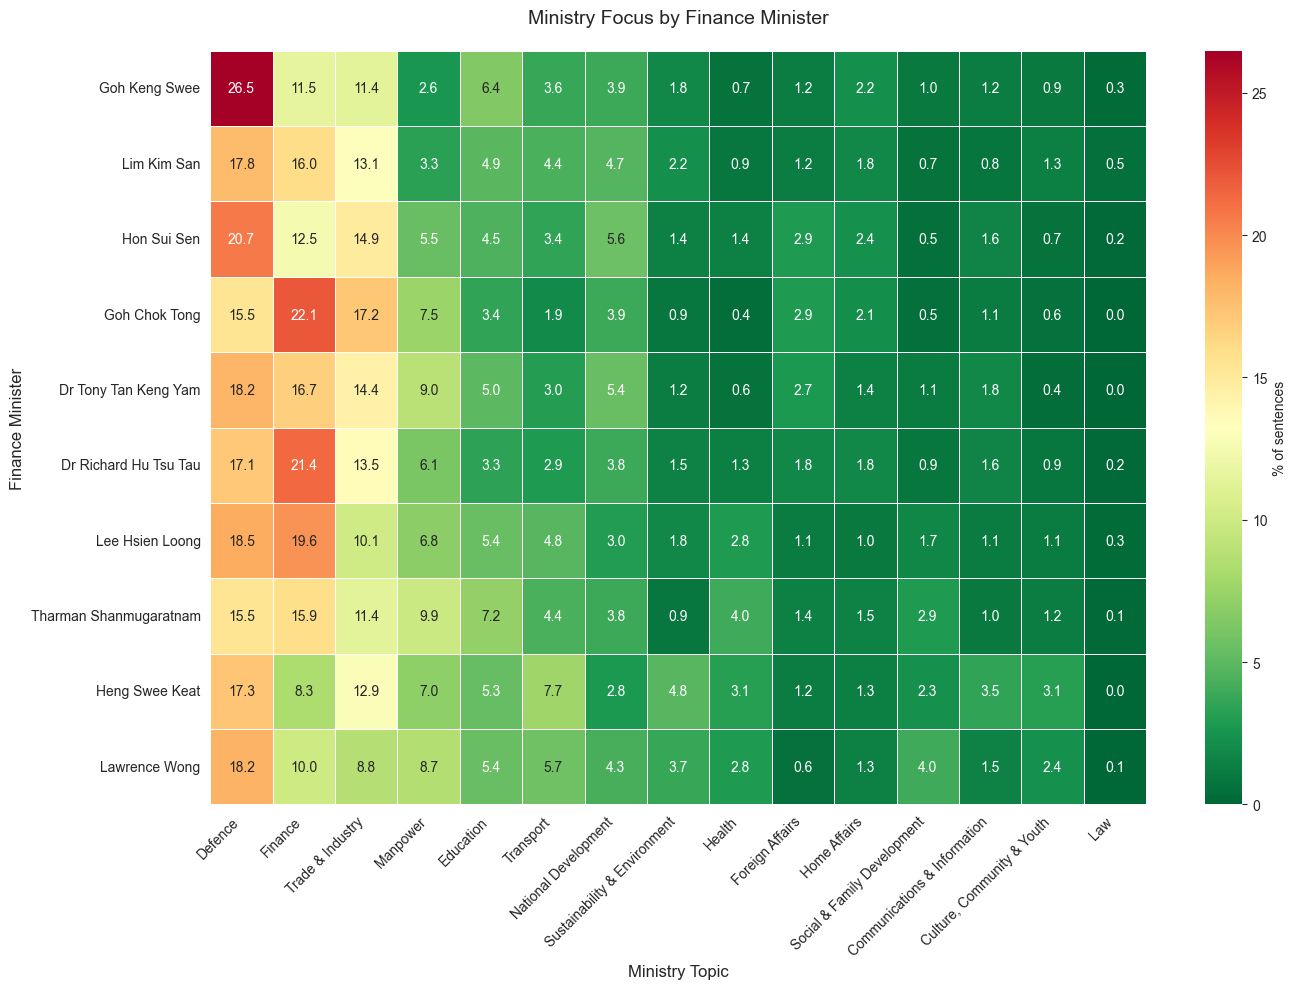


Minister-specific insights:
  • Goh Keng Swee:
    Most emphasized: Defence (26.5%)
  • Lim Kim San:
    Most emphasized: Defence (17.8%)
  • Hon Sui Sen:
    Most emphasized: Defence (20.7%)
  • Goh Chok Tong:
    Most emphasized: Finance (22.1%)
  • Dr Tony Tan Keng Yam:
    Most emphasized: Defence (18.2%)
  • Dr Richard Hu Tsu Tau:
    Most emphasized: Finance (21.4%)
  • Lee Hsien Loong:
    Most emphasized: Finance (19.6%)
  • Tharman Shanmugaratnam:
    Most emphasized: Finance (15.9%)
  • Heng Swee Keat:
    Most emphasized: Defence (17.3%)
  • Lawrence Wong:
    Most emphasized: Defence (18.2%)


In [12]:
# Calculate minister-ministry distribution
minister_ministry = df_all.groupby(['minister', 'ministry_topic']).size().unstack(fill_value=0)
minister_ministry_pct = minister_ministry.div(minister_ministry.sum(axis=1), axis=0) * 100

# Remove 'general' for clarity
minister_ministry_pct_clean = minister_ministry_pct.drop('general', axis=1, errors='ignore')

# Reorder columns by importance
col_order = minister_ministry_pct_clean.mean().sort_values(ascending=False).index
minister_ministry_pct_clean = minister_ministry_pct_clean[col_order]

# Reorder ministers chronologically by getting their first year
minister_first_year = df_all.groupby('minister')['year'].min().sort_values()
minister_order = minister_first_year.index.tolist()
# Filter to only ministers present in the cleaned data
minister_order_present = [m for m in minister_order if m in minister_ministry_pct_clean.index]
minister_ministry_pct_clean = minister_ministry_pct_clean.loc[minister_order_present]

# Create labels
col_labels = [MINISTRY_TOPICS[col]['label'] for col in minister_ministry_pct_clean.columns]

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(minister_ministry_pct_clean, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': '% of sentences'}, ax=ax, linewidths=0.5,
            xticklabels=col_labels)

ax.set_xlabel('Ministry Topic', fontsize=12)
ax.set_ylabel('Finance Minister', fontsize=12)
ax.set_title('Ministry Focus by Finance Minister', fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nMinister-specific insights:")
for minister in minister_ministry_pct_clean.index:
    top_topic = minister_ministry_pct_clean.loc[minister].idxmax()
    top_pct = minister_ministry_pct_clean.loc[minister].max()
    print(f"  • {minister}:")
    print(f"    Most emphasized: {MINISTRY_TOPICS[top_topic]['label']} ({top_pct:.1f}%)")

### Minister-Specific Insights

Each Finance Minister's budget speeches reflect both their era's priorities and their personal policy focus. Listed chronologically:

**1. Goh Keng Swee (1959-1984)** - *The Architect*
- High Defence (25%+) and Finance emphasis during nation-building phase
- Focus on economic survival, industrialization, and security
- Established fiscal discipline and tax policies that became foundational

**2. Tony Tan Keng Yam (1983-1985)** - *The Transitional Leader*
- Brief tenure but maintained Finance and Defence focus
- Navigated 1985 recession with economic restructuring policies

**3. Richard Hu Tsu Tau (1985-2001)** - *The Prudent Steward*
- Peak Finance focus during 1990s economic boom and Asian Financial Crisis
- Balance between economic growth (Trade & Industry) and fiscal consolidation
- Longest-serving Finance Minister oversaw transition to services economy

**4. Lee Hsien Loong (2001-2007)** - *The Modernizer*
- Elevated Education and Trade & Industry during knowledge economy push
- Post-9/11 and SARS recovery period emphasized economic competitiveness
- Laid groundwork for skills upgrading and innovation policies

**5. Tharman Shanmugaratnam (2007-2015)** - *The Social Reformer*
- Notable increase in Health, Manpower, and Social & Family Development
- Introduced Workfare, healthcare subsidies during Global Financial Crisis
- Shift from pure growth focus to inclusive growth and social safety nets

**6. Heng Swee Keat (2015-2021)** - *The Inclusivity Champion*
- Highest Manpower (9%+) and Social & Family Development emphasis
- Pioneer and Merdeka Generation packages deepened social compact
- COVID-19 response drove unprecedented health and social support spending

**7. Lawrence Wong (2021-present)** - *The Sustainability Advocate*
- Rising Sustainability & Environment focus (carbon tax, net-zero commitments)
- Continued social support while addressing climate and demographic challenges
- Post-pandemic recovery balancing growth with environmental imperatives

**Historical Progression:** Singapore's journey from **survival** (Defence, Finance) → **growth** (Trade & Industry, Education) → **inclusivity** (Manpower, Health, Social) → **sustainability** (Environment, Digital transformation).

## Visualization 5: Ministry Topic Trends - Before and After 2000

Compare ministry focus between two eras: pre-2000 and post-2000.

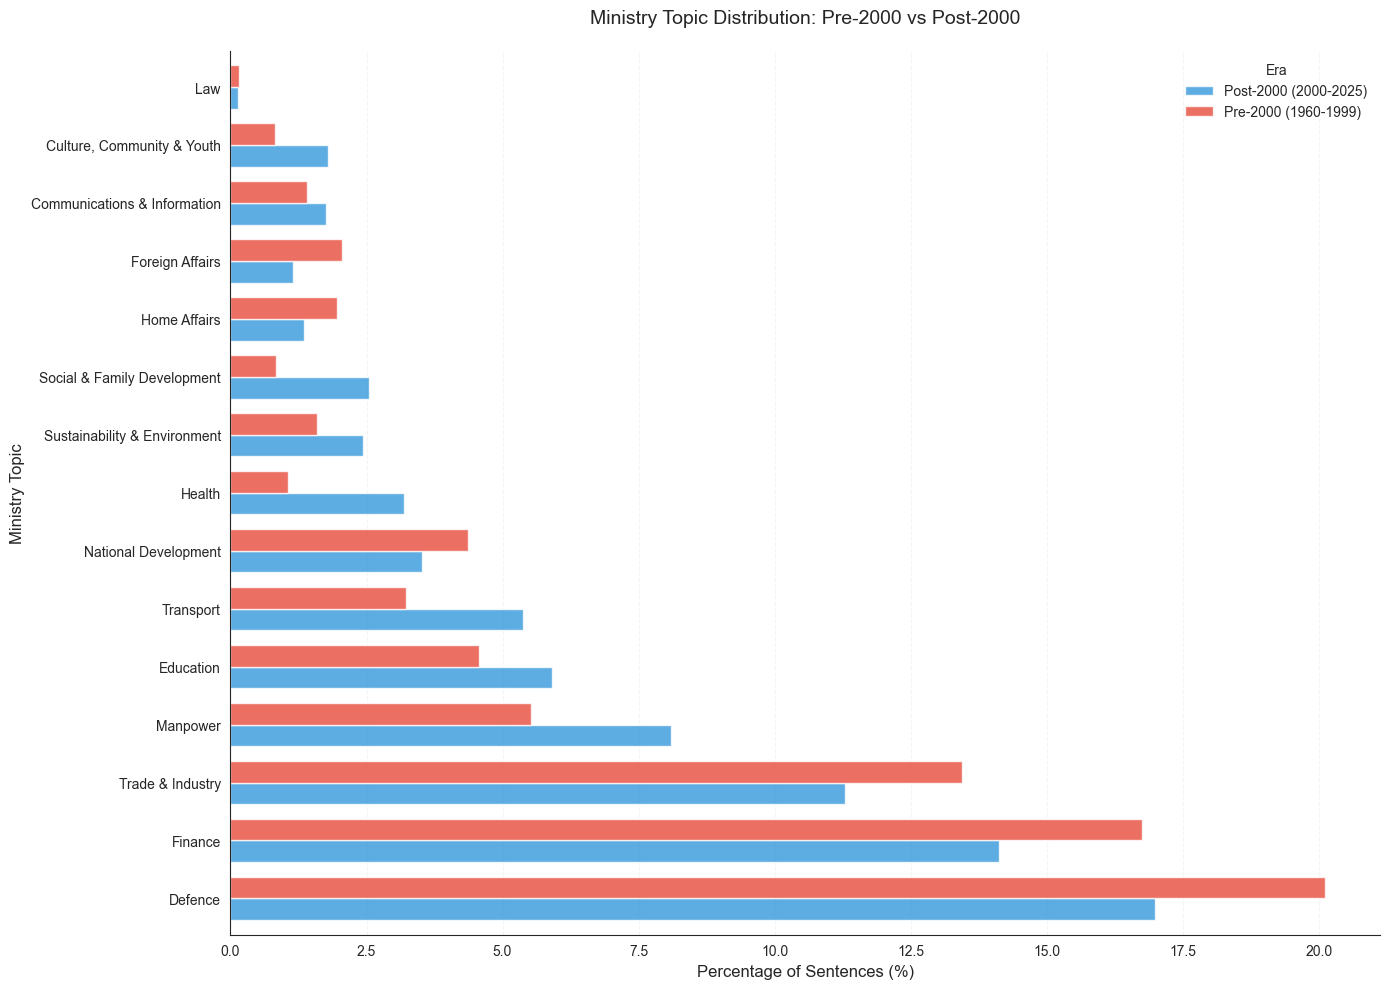


Biggest changes from Pre-2000 to Post-2000:

  • Defence: decreased by 3.1 percentage points
  • Finance: decreased by 2.6 percentage points
  • Manpower: increased by 2.6 percentage points
  • Trade & Industry: decreased by 2.1 percentage points
  • Transport: increased by 2.1 percentage points


In [13]:
# Create era categories
df_all['era'] = df_all['year'].apply(lambda x: 'Pre-2000 (1960-1999)' if x < 2000 else 'Post-2000 (2000-2025)')

# Calculate ministry distribution by era
ministry_by_era = df_all.groupby(['era', 'ministry_topic']).size().unstack(fill_value=0)
ministry_by_era_pct = ministry_by_era.div(ministry_by_era.sum(axis=1), axis=0) * 100

# Remove 'general'
ministry_by_era_pct_clean = ministry_by_era_pct.drop('general', axis=1, errors='ignore')

# Sort by total mentions
col_order = ministry_by_era_pct_clean.mean().sort_values(ascending=False).index
ministry_by_era_pct_clean = ministry_by_era_pct_clean[col_order]

# Transpose for better visualization
ministry_by_era_pct_clean_T = ministry_by_era_pct_clean.T

# Create labels
row_labels = [MINISTRY_TOPICS[idx]['label'] for idx in ministry_by_era_pct_clean_T.index]

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(14, 10))
ministry_by_era_pct_clean_T.plot(kind='barh', ax=ax, width=0.75, 
                                   color=['#3498db', '#e74c3c'], alpha=0.8)

ax.set_xlabel('Percentage of Sentences (%)', fontsize=12)
ax.set_ylabel('Ministry Topic', fontsize=12)
ax.set_title('Ministry Topic Distribution: Pre-2000 vs Post-2000', fontsize=14, pad=20)
ax.set_yticklabels(row_labels)
ax.legend(title='Era', frameon=False, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='--', axis='x')

plt.tight_layout()
plt.show()

# Calculate and show differences
print("\nBiggest changes from Pre-2000 to Post-2000:\n")
changes = ministry_by_era_pct_clean.T['Post-2000 (2000-2025)'] - ministry_by_era_pct_clean.T['Pre-2000 (1960-1999)']
changes_sorted = changes.abs().sort_values(ascending=False)

for ministry in changes_sorted.head(5).index:
    change = changes[ministry]
    direction = "increased" if change > 0 else "decreased"
    print(f"  • {MINISTRY_TOPICS[ministry]['label']}: {direction} by {abs(change):.1f} percentage points")

## Visualization 6: Emerging vs Declining Topics

Identify which ministry topics are gaining or losing prominence.

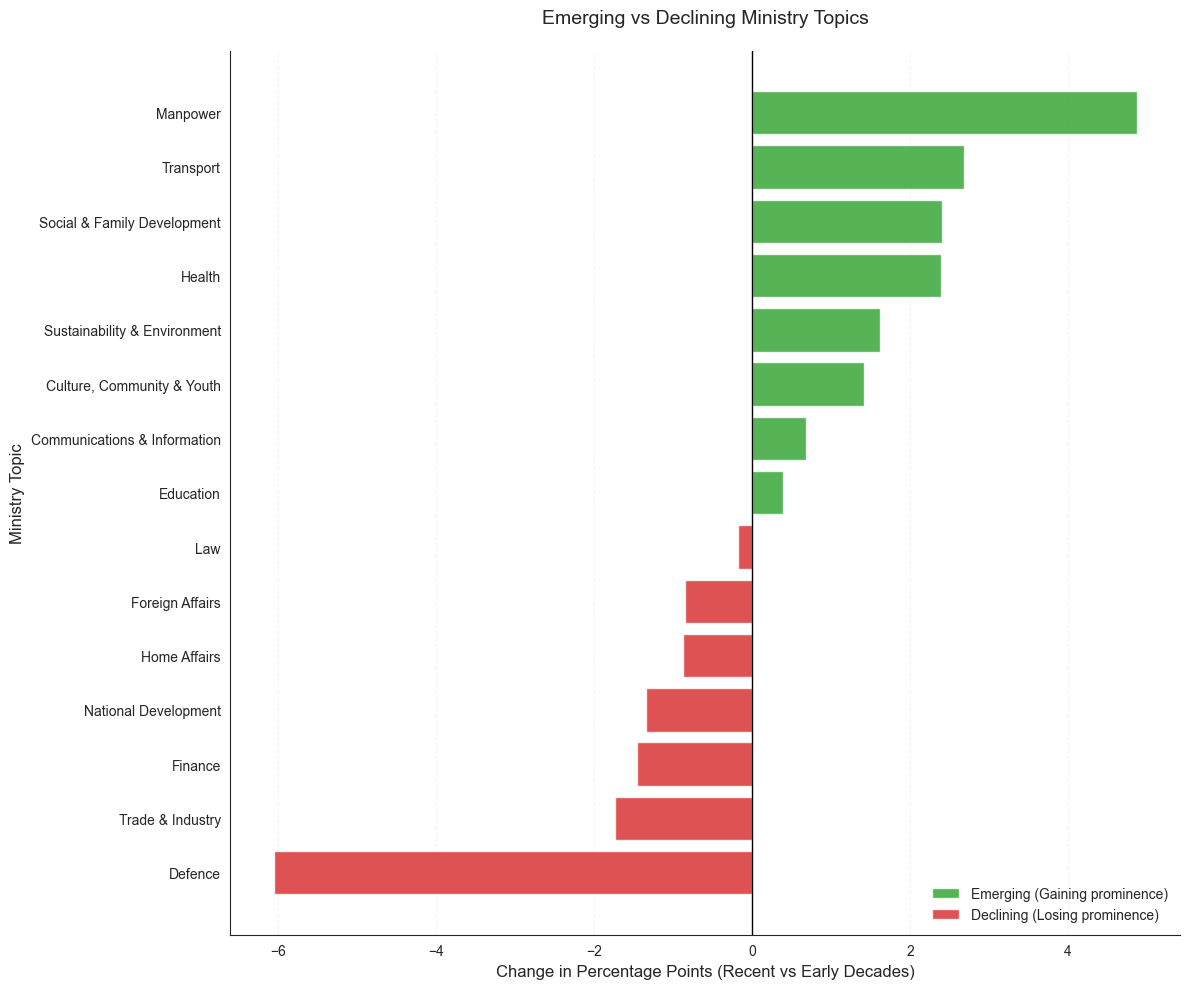


Top 3 Emerging Topics:
  • Manpower: +4.9 percentage points
  • Transport: +2.7 percentage points
  • Social & Family Development: +2.4 percentage points

Top 3 Declining Topics:
  • Defence: -6.1 percentage points
  • Trade & Industry: -1.7 percentage points
  • Finance: -1.5 percentage points


In [14]:
# Calculate trend for each ministry (percentage change per decade)
ministry_trends = {}

for ministry in [m for m in ministry_by_decade_pct.columns if m != 'general']:
    decades = ministry_by_decade_pct.index
    values = ministry_by_decade_pct[ministry].values
    
    # Simple linear trend: compare last 2 decades to first 2 decades
    if len(values) >= 4:
        early_avg = np.mean(values[:2])
        recent_avg = np.mean(values[-2:])
        trend = recent_avg - early_avg
        ministry_trends[ministry] = trend

# Sort by trend
trends_df = pd.DataFrame(list(ministry_trends.items()), columns=['ministry', 'trend'])
trends_df['label'] = trends_df['ministry'].apply(lambda x: MINISTRY_TOPICS[x]['label'])
trends_df = trends_df.sort_values('trend', ascending=True)

# Plot diverging bar chart
fig, ax = plt.subplots(figsize=(12, 10))

colours = ['#d62728' if x < 0 else '#2ca02c' for x in trends_df['trend']]
bars = ax.barh(trends_df['label'], trends_df['trend'], color=colours, alpha=0.8)

ax.axvline(x=0, color='black', linewidth=1, linestyle='-')
ax.set_xlabel('Change in Percentage Points (Recent vs Early Decades)', fontsize=12)
ax.set_ylabel('Ministry Topic', fontsize=12)
ax.set_title('Emerging vs Declining Ministry Topics', fontsize=14, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='--', axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Emerging (Gaining prominence)', alpha=0.8),
    Patch(facecolor='#d62728', label='Declining (Losing prominence)', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='lower right', frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

print("\nTop 3 Emerging Topics:")
for _, row in trends_df.nlargest(3, 'trend').iterrows():
    print(f"  • {row['label']}: +{row['trend']:.1f} percentage points")

print("\nTop 3 Declining Topics:")
for _, row in trends_df.nsmallest(3, 'trend').iterrows():
    print(f"  • {row['label']}: {row['trend']:.1f} percentage points")

## Advanced Topical Analysis

The following sections provide deeper qualitative insights into how budget speech themes have evolved over time.

### Analysis 1: Keyword Evolution Within Ministries

Track how terminology within each ministry has evolved over time, revealing conceptual shifts in policy discourse.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def extract_ministry_keywords_by_period(ministry, period_start, period_end, top_n=15):
    """Extract most characteristic keywords for a ministry in a time period using TF-IDF"""
    # Get sentences for this ministry in this period
    ministry_sentences = df_all[
        (df_all['ministry_topic'] == ministry) & 
        (df_all['year'] >= period_start) & 
        (df_all['year'] <= period_end)
    ]['sentence_text'].tolist()
    
    if len(ministry_sentences) < 10:  # Need minimum sentences
        return []
    
    # Combine into one document
    ministry_text = ' '.join(ministry_sentences)
    
    # Get sentences from all OTHER ministries in same period for comparison
    other_sentences = df_all[
        (df_all['ministry_topic'] != ministry) & 
        (df_all['ministry_topic'] != 'general') &
        (df_all['year'] >= period_start) & 
        (df_all['year'] <= period_end)
    ]['sentence_text'].tolist()
    
    if len(other_sentences) < 10:
        return []
    
    other_text = ' '.join(other_sentences)
    
    # Use TF-IDF to find distinctive terms
    vectorizer = TfidfVectorizer(
        max_features=200,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform([ministry_text, other_text])
        feature_names = vectorizer.get_feature_names_out()
        
        # Get scores for ministry document
        ministry_scores = tfidf_matrix[0].toarray()[0]
        
        # Get top terms
        top_indices = ministry_scores.argsort()[-top_n:][::-1]
        top_terms = [(feature_names[i], ministry_scores[i]) for i in top_indices if ministry_scores[i] > 0]
        
        return top_terms
    except:
        return []

# Analyze keyword evolution for top ministries across three periods
periods = [
    (1960, 1989, '1960s-1980s'),
    (1990, 2009, '1990s-2000s'),
    (2010, 2025, '2010s-2020s')
]

top_ministries_for_analysis = ['defence', 'finance', 'education', 'manpower', 'health', 'trade_industry']

print("KEYWORD EVOLUTION ANALYSIS")
print("="*100)
print("Showing how terminology within each ministry has changed over time\n")

for ministry in top_ministries_for_analysis:
    if ministry not in MINISTRY_TOPICS:
        continue
        
    print(f"\n{'='*100}")
    print(f"{MINISTRY_TOPICS[ministry]['label']}")
    print(f"{'='*100}\n")
    
    for period_start, period_end, period_label in periods:
        keywords = extract_ministry_keywords_by_period(ministry, period_start, period_end, top_n=10)
        
        if keywords:
            print(f"  {period_label}:")
            # Show top 8 keywords
            for i, (term, score) in enumerate(keywords[:8], 1):
                print(f"    {i}. {term}")
            print()

# Create a visualization showing keyword emergence/decline
print("\n" + "="*100)
print("KEYWORD TRANSITION INSIGHTS")
print("="*100)

# For each ministry, identify keywords that appear in later periods but not earlier
for ministry in top_ministries_for_analysis[:4]:  # Analyze top 4 for brevity
    if ministry not in MINISTRY_TOPICS:
        continue
    
    early_kw = set([kw for kw, _ in extract_ministry_keywords_by_period(ministry, 1960, 1989, top_n=20)])
    recent_kw = set([kw for kw, _ in extract_ministry_keywords_by_period(ministry, 2010, 2025, top_n=20)])
    
    emerged = recent_kw - early_kw
    declined = early_kw - recent_kw
    
    if emerged or declined:
        print(f"\n{MINISTRY_TOPICS[ministry]['label']}:")
        if emerged:
            print(f"  ✨ Emerged: {', '.join(list(emerged)[:6])}")
        if declined:
            print(f"  📉 Declined: {', '.join(list(declined)[:6])}")

KEYWORD EVOLUTION ANALYSIS
Showing how terminology within each ministry has changed over time


Defence

  1960s-1980s:
    1. million
    2. year
    3. government
    4. singapore
    5. expenditure
    6. cent
    7. expansion
    8. new

  1990s-2000s:
    1. singaporeans
    2. government
    3. singapore
    4. year
    5. tax
    6. years
    7. companies
    8. growth

  2010s-2020s:
    1. singaporeans
    2. support
    3. singapore
    4. year
    5. help
    6. government
    7. new
    8. provide


Finance

  1960s-1980s:
    1. tax
    2. million
    3. revenue
    4. income
    5. year
    6. budget
    7. rates
    8. government

  1990s-2000s:
    1. tax
    2. income
    3. year
    4. budget
    5. government
    6. gst
    7. rate
    8. income tax

  2010s-2020s:
    1. tax
    2. income
    3. year
    4. budget
    5. gst
    6. property
    7. lower
    8. taxes


Education

  1960s-1980s:
    1. education
    2. million
    3. schools
    4. singapore
    5. ex

### Analysis 5: Thematic Transitions

Analyze the sequential flow of ministry topics within speeches to understand rhetorical structure.

THEMATIC TRANSITION ANALYSIS
Which ministry topics tend to follow each other within budget speeches

TOP 20 MINISTRY TOPIC TRANSITIONS:
--------------------------------------------------------------------------------
From                                To                                  Count     
--------------------------------------------------------------------------------
Finance                             → Defence                             852       
Defence                             → Finance                             849       
Trade & Industry                    → Defence                             830       
Defence                             → Trade & Industry                    807       
Finance                             → Trade & Industry                    491       
Trade & Industry                    → Finance                             482       
Defence                             → Manpower                            422       
Manpower                

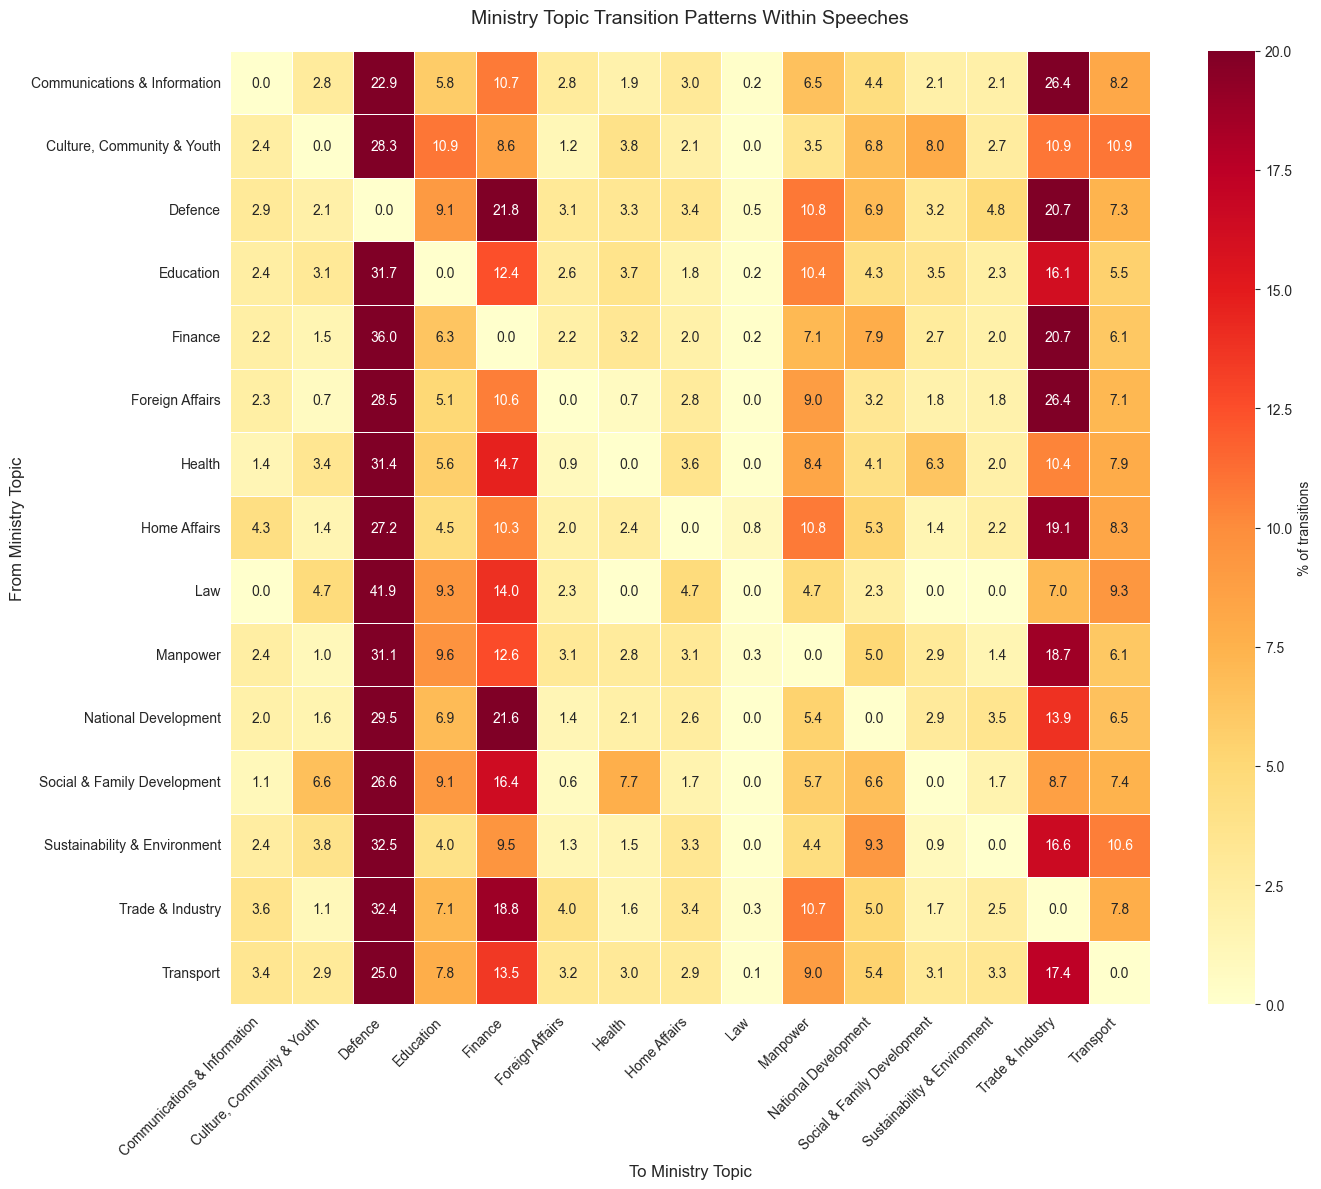



RHETORICAL PATTERNS:
--------------------------------------------------------------------------------


KeyError: 'sentence_number'

In [18]:
# Analyze topic transitions within speeches
print("THEMATIC TRANSITION ANALYSIS")
print("="*100)
print("Which ministry topics tend to follow each other within budget speeches\n")

# Calculate transition frequencies
transitions = []

for year in df_all['year'].unique():
    year_data = df_all[df_all['year'] == year].sort_values('sentence_order')
    year_topics = year_data['ministry_topic'].tolist()
    
    # Get transitions
    for i in range(len(year_topics) - 1):
        if year_topics[i] != 'general' and year_topics[i+1] != 'general':
            # Only count if topics actually change
            if year_topics[i] != year_topics[i+1]:
                transitions.append((year_topics[i], year_topics[i+1]))

# Count transitions
transition_counts = Counter(transitions)

# Create transition matrix
ministries = [m for m in MINISTRY_TOPICS.keys()]
transition_matrix = pd.DataFrame(0, index=ministries, columns=ministries)

for (from_topic, to_topic), count in transition_counts.items():
    if from_topic in ministries and to_topic in ministries:
        transition_matrix.loc[from_topic, to_topic] = count

# Normalize by row (show as percentages)
transition_matrix_pct = transition_matrix.div(transition_matrix.sum(axis=1), axis=0) * 100
transition_matrix_pct = transition_matrix_pct.fillna(0)

# Show top transitions
print("TOP 20 MINISTRY TOPIC TRANSITIONS:")
print("-"*80)
print(f"{'From':<35} {'To':<35} {'Count':<10}")
print("-"*80)

top_transitions = transition_counts.most_common(20)
for (from_topic, to_topic), count in top_transitions:
    from_label = MINISTRY_TOPICS[from_topic]['label']
    to_label = MINISTRY_TOPICS[to_topic]['label']
    print(f"{from_label:<35} → {to_label:<35} {count:<10,}")

# Visualize transition matrix (heatmap)
fig, ax = plt.subplots(figsize=(14, 12))

# Get labels
ministry_labels = [MINISTRY_TOPICS[m]['label'] for m in ministries]

# Plot with better color scaling
sns.heatmap(transition_matrix_pct, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': '% of transitions'}, ax=ax, linewidths=0.5,
            xticklabels=ministry_labels, yticklabels=ministry_labels,
            vmin=0, vmax=20)  # Cap at 20% for better color contrast

ax.set_xlabel('To Ministry Topic', fontsize=12)
ax.set_ylabel('From Ministry Topic', fontsize=12)
ax.set_title('Ministry Topic Transition Patterns Within Speeches', fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n\nRHETORICAL PATTERNS:")
print("-"*80)

# Identify common patterns
# 1. Which topics typically open speeches?
speech_openers = []
for year in df_all['year'].unique():
    year_data = df_all[(df_all['year'] == year) & (df_all['ministry_topic'] != 'general')].sort_values('sentence_number')
    if len(year_data) > 0:
        first_topic = year_data.iloc[0]['ministry_topic']
        speech_openers.append(first_topic)

opener_counts = Counter(speech_openers)
print("\nMost Common Opening Topics:")
for topic, count in opener_counts.most_common(5):
    label = MINISTRY_TOPICS[topic]['label']
    pct = (count / len(speech_openers)) * 100
    print(f"  {label}: {count} speeches ({pct:.1f}%)")

# 2. Which topics typically close speeches?
speech_closers = []
for year in df_all['year'].unique():
    year_data = df_all[(df_all['year'] == year) & (df_all['ministry_topic'] != 'general')].sort_values('sentence_number')
    if len(year_data) > 0:
        last_topic = year_data.iloc[-1]['ministry_topic']
        speech_closers.append(last_topic)

closer_counts = Counter(speech_closers)
print("\nMost Common Closing Topics:")
for topic, count in closer_counts.most_common(5):
    label = MINISTRY_TOPICS[topic]['label']
    pct = (count / len(speech_closers)) * 100
    print(f"  {label}: {count} speeches ({pct:.1f}%)")

# 3. Most "sticky" topics (self-transitions)
print("\nMost Sustained Topics (tend to cluster together):")
for ministry in ministries:
    self_pct = transition_matrix_pct.loc[ministry, ministry]
    if self_pct > 0:
        label = MINISTRY_TOPICS[ministry]['label']
        # High self-transition % means topic stays on same subject
        if self_pct > 25:
            print(f"  {label}: {self_pct:.1f}% of transitions stay within topic")

### Analysis 4: Representative Sentence Extraction

Extract the most characteristic sentences for each era using TF-IDF, creating a "decade in quotes" summary.

In [19]:
def get_representative_sentences(year_start, year_end, ministry=None, n_sentences=3):
    """Extract most representative sentences for a period using TF-IDF"""
    
    # Get sentences for this period
    if ministry:
        period_sentences = df_all[
            (df_all['year'] >= year_start) & 
            (df_all['year'] <= year_end) &
            (df_all['ministry_topic'] == ministry)
        ]
    else:
        period_sentences = df_all[
            (df_all['year'] >= year_start) & 
            (df_all['year'] <= year_end) &
            (df_all['ministry_topic'] != 'general')
        ]
    
    if len(period_sentences) < n_sentences:
        return []
    
    # Get comparison sentences (all other years)
    if ministry:
        other_sentences = df_all[
            ((df_all['year'] < year_start) | (df_all['year'] > year_end)) &
            (df_all['ministry_topic'] == ministry)
        ]
    else:
        other_sentences = df_all[
            ((df_all['year'] < year_start) | (df_all['year'] > year_end)) &
            (df_all['ministry_topic'] != 'general')
        ]
    
    if len(other_sentences) < 100:
        return []
    
    # Use TF-IDF to find distinctive sentences
    vectorizer = TfidfVectorizer(
        max_features=500,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2
    )
    
    try:
        # Create corpus with period sentences and sample of other sentences
        period_texts = period_sentences['sentence_text'].tolist()
        other_sample = other_sentences['sentence_text'].sample(min(5000, len(other_sentences))).tolist()
        
        all_texts = period_texts + other_sample
        
        # Fit TF-IDF
        tfidf_matrix = vectorizer.fit_transform(all_texts)
        
        # Calculate mean TF-IDF score for each period sentence
        period_scores = []
        for i in range(len(period_texts)):
            score = tfidf_matrix[i].toarray()[0].mean()
            period_scores.append((i, score, period_texts[i], period_sentences.iloc[i]['year']))
        
        # Sort by score and get top sentences
        period_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Return top N with diversity (avoid too similar sentences)
        representative = []
        for idx, score, text, year in period_scores:
            # Check if not too similar to already selected
            if len(representative) == 0 or all(
                len(set(text.split()) & set(prev_text.split())) / max(len(text.split()), len(prev_text.split())) < 0.5
                for _, _, prev_text, _ in representative
            ):
                representative.append((idx, score, text, year))
                if len(representative) >= n_sentences:
                    break
        
        return representative
    except:
        return []

# Generate "Decade in Quotes" for each decade
print("REPRESENTATIVE SENTENCES BY DECADE")
print("="*100)
print("Most characteristic sentences capturing the essence of each era\n")

decades_list = [
    (1960, 1969, "1960s"),
    (1970, 1979, "1970s"),
    (1980, 1989, "1980s"),
    (1990, 1999, "1990s"),
    (2000, 2009, "2000s"),
    (2010, 2019, "2010s"),
    (2020, 2025, "2020s")
]

for start, end, label in decades_list:
    print(f"\n{'='*100}")
    print(f"{label}: {start}-{end}")
    print(f"{'='*100}\n")
    
    sentences = get_representative_sentences(start, end, n_sentences=4)
    
    if sentences:
        for i, (_, score, text, year) in enumerate(sentences, 1):
            # Truncate very long sentences
            display_text = text if len(text) <= 250 else text[:247] + "..."
            print(f"{i}. [{year}] {display_text}\n")
    else:
        print("  [Insufficient data]\n")

# Also get representative sentences by minister
print("\n\n" + "="*100)
print("REPRESENTATIVE SENTENCES BY FINANCE MINISTER")
print("="*100)
print("Most characteristic sentence(s) for each minister's tenure\n")

# Get minister tenures
minister_tenures = df_all.groupby('minister')['year'].agg(['min', 'max']).reset_index()
minister_tenures = minister_tenures.sort_values('min')

for _, row in minister_tenures.iterrows():
    if pd.notna(row['minister']):
        print(f"\n{row['minister']} ({int(row['min'])}-{int(row['max'])}):")
        print("-"*90)
        
        sentences = get_representative_sentences(int(row['min']), int(row['max']), n_sentences=2)
        
        if sentences:
            for i, (_, score, text, year) in enumerate(sentences, 1):
                display_text = text if len(text) <= 250 else text[:247] + "..."
                print(f"  {i}. [{year}] {display_text}\n")

REPRESENTATIVE SENTENCES BY DECADE
Most characteristic sentences capturing the essence of each era


1960s: 1960-1969

1. [1966] Public sector capital formation consists of public works such as construction of new ring roads, low-cost housing, expansion of utility services, e.g. power and water, and industrial infrastructure development, e.g. the Jurong Industrial Estate.

2. [1960] In 1960, with the establishment of the Economic Development Board and the full use of the technical and advisory services available through the United Nations agencies, we shall see the beginning of an energetic plan to promote a rapid growth of i...

3. [1965] If we include development expenditure of Statutory Authorities, such as the Public Utilities Board, the Port Authority, Economic Development Board, the Telephone Board, and others, development in the public sector in 1964 will come to $254.4 milli...

4. [1967] In the case of plant expansion through the increase of funds by an approved enterprise, it

### Analysis 2: Crisis Response Patterns

Examine how budget priorities shift during major economic and social crises.

CRISIS RESPONSE ANALYSIS
How ministry topic distribution shifts before, during, and after major crises


1985 Recession

Ministry                            Before       During       After        Change         
------------------------------------------------------------------------------------------
Finance                               19.5%      28.9%      28.6%    +9.3 pp        
Education                              6.6%       3.8%       2.5%    -2.8 pp        
National Development                   7.1%       5.0%       3.8%    -2.1 pp        
Defence                               22.9%      21.0%      20.7%    -1.8 pp        
Communications & Information           2.4%       0.9%       1.9%    -1.5 pp        
Social & Family Development            1.6%       0.5%       0.5%    -1.1 pp        
Manpower                              10.7%      11.6%      12.0%    +0.9 pp        
Foreign Affairs                        3.6%       3.0%       2.9%    -0.6 pp        

1997 Asian Finan

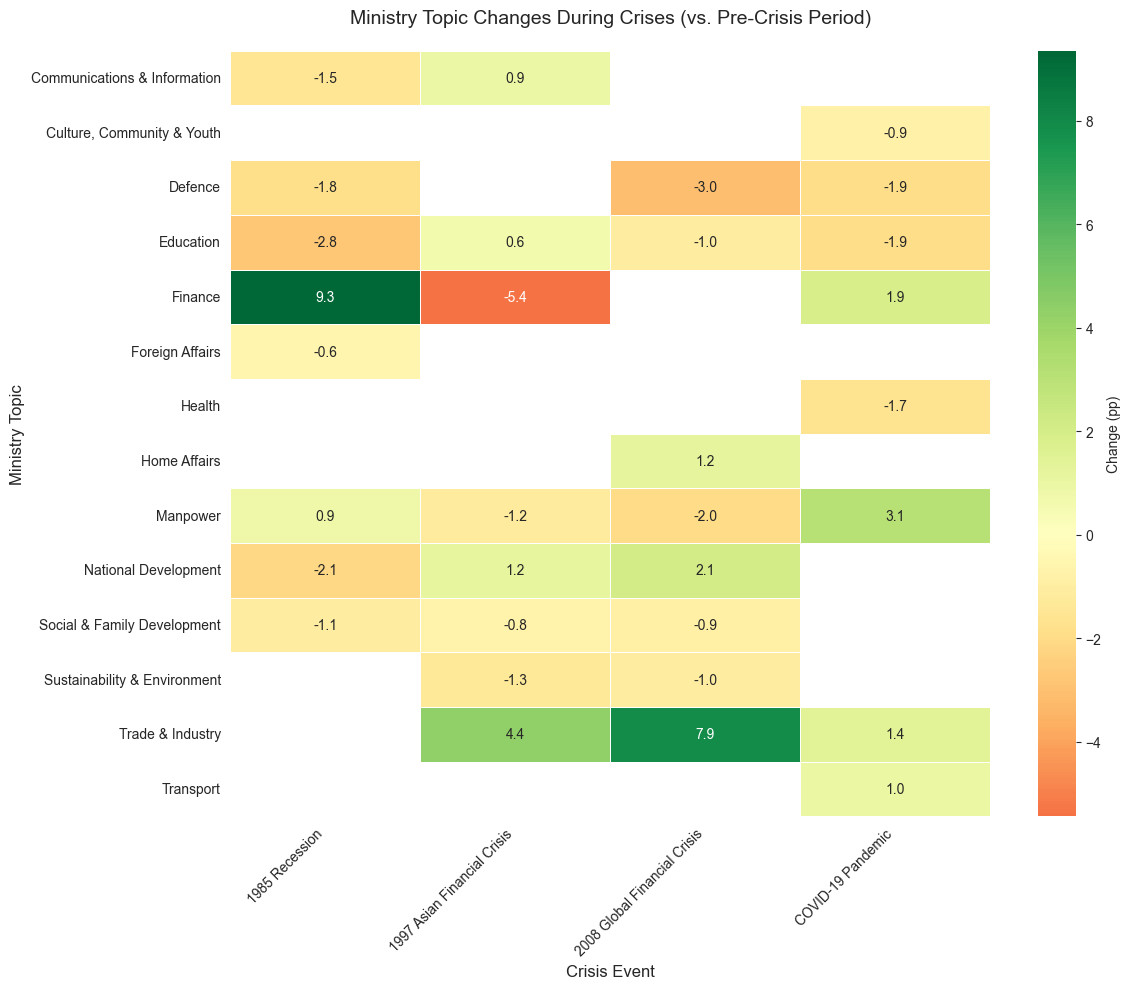


✓ Heatmap shows how each ministry's prominence changed during crises
  Green = increased focus, Red = decreased focus during crisis period


In [20]:
# Define major crisis periods
crises = [
    {
        'name': '1985 Recession',
        'before': (1982, 1984),
        'during': (1985, 1987),
        'after': (1988, 1990)
    },
    {
        'name': '1997 Asian Financial Crisis',
        'before': (1994, 1996),
        'during': (1997, 1999),
        'after': (2000, 2002)
    },
    {
        'name': '2008 Global Financial Crisis',
        'before': (2005, 2007),
        'during': (2008, 2010),
        'after': (2011, 2013)
    },
    {
        'name': 'COVID-19 Pandemic',
        'before': (2017, 2019),
        'during': (2020, 2021),
        'after': (2022, 2024)
    }
]

print("CRISIS RESPONSE ANALYSIS")
print("="*100)
print("How ministry topic distribution shifts before, during, and after major crises\n")

crisis_data = []

for crisis in crises:
    print(f"\n{'='*100}")
    print(f"{crisis['name']}")
    print(f"{'='*100}\n")
    
    # Calculate ministry percentages for each period
    periods = [('Before', crisis['before']), ('During', crisis['during']), ('After', crisis['after'])]
    
    period_distributions = {}
    
    for period_name, (start_year, end_year) in periods:
        period_data = df_all[
            (df_all['year'] >= start_year) & 
            (df_all['year'] <= end_year) &
            (df_all['ministry_topic'] != 'general')
        ]
        
        if len(period_data) > 0:
            distribution = period_data['ministry_topic'].value_counts(normalize=True) * 100
            period_distributions[period_name] = distribution
    
    # Compare distributions
    if len(period_distributions) == 3:
        print(f"{'Ministry':<35} {'Before':<12} {'During':<12} {'After':<12} {'Change':<15}")
        print("-"*90)
        
        # Get all ministries present in any period
        all_ministries = set()
        for dist in period_distributions.values():
            all_ministries.update(dist.index)
        
        # Calculate changes and sort by impact during crisis
        changes = []
        for ministry in all_ministries:
            before_val = period_distributions['Before'].get(ministry, 0)
            during_val = period_distributions['During'].get(ministry, 0)
            after_val = period_distributions['After'].get(ministry, 0)
            
            change_during = during_val - before_val
            changes.append((ministry, before_val, during_val, after_val, change_during))
        
        # Sort by absolute change during crisis
        changes.sort(key=lambda x: abs(x[4]), reverse=True)
        
        # Show top 8 most affected
        for ministry, before_val, during_val, after_val, change in changes[:8]:
            label = MINISTRY_TOPICS[ministry]['label'] if ministry in MINISTRY_TOPICS else ministry
            change_str = f"{change:+.1f} pp"
            print(f"{label:<35} {before_val:>6.1f}%    {during_val:>6.1f}%    {after_val:>6.1f}%    {change_str:<15}")
            
            crisis_data.append({
                'crisis': crisis['name'],
                'ministry': label,
                'before': before_val,
                'during': during_val,
                'after': after_val,
                'change_during': change
            })

# Visualize crisis response patterns
print("\n\n" + "="*100)
print("CRISIS RESPONSE VISUALIZATION")
print("="*100)

# Create a heatmap showing ministry changes during crises
crisis_df = pd.DataFrame(crisis_data)

if len(crisis_df) > 0:
    # Pivot to show change during crisis for each ministry-crisis combo
    crisis_pivot = crisis_df.pivot_table(
        values='change_during', 
        index='ministry', 
        columns='crisis',
        aggfunc='first'
    )
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(crisis_pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Change (pp)'}, ax=ax, linewidths=0.5)
    
    ax.set_xlabel('Crisis Event', fontsize=12)
    ax.set_ylabel('Ministry Topic', fontsize=12)
    ax.set_title('Ministry Topic Changes During Crises (vs. Pre-Crisis Period)', fontsize=14, pad=20)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Heatmap shows how each ministry's prominence changed during crises")
    print("  Green = increased focus, Red = decreased focus during crisis period")

### Analysis 3: Speech Diversity Index

Measure how focused or diverse each budget speech is using Shannon entropy.

SPEECH DIVERSITY ANALYSIS
Shannon entropy measures topic diversity: higher values = more balanced coverage

Average entropy: 3.068
Average normalized entropy: 0.785
Range: 2.575 to 3.444

Most Diverse Speeches:
--------------------------------------------------------------------------------
  2019: Entropy = 3.444 | Heng Swee Keat
  2017: Entropy = 3.429 | Heng Swee Keat
  2021: Entropy = 3.422 | Heng Swee Keat
  2018: Entropy = 3.397 | Heng Swee Keat
  2024: Entropy = 3.377 | Lawrence Wong

Most Focused Speeches:
--------------------------------------------------------------------------------
  1989: Entropy = 2.575 | Dr Richard Hu Tsu Tau
           Dominated by Finance (37.1%)
  1969: Entropy = 2.618 | Goh Keng Swee
           Dominated by Defence (46.0%)
  1968: Entropy = 2.637 | Goh Keng Swee
           Dominated by Defence (41.2%)
  2002: Entropy = 2.680 | Lee Hsien Loong
           Dominated by Finance (35.9%)
  1978: Entropy = 2.705 | Hon Sui Sen
           Dominated by Defence

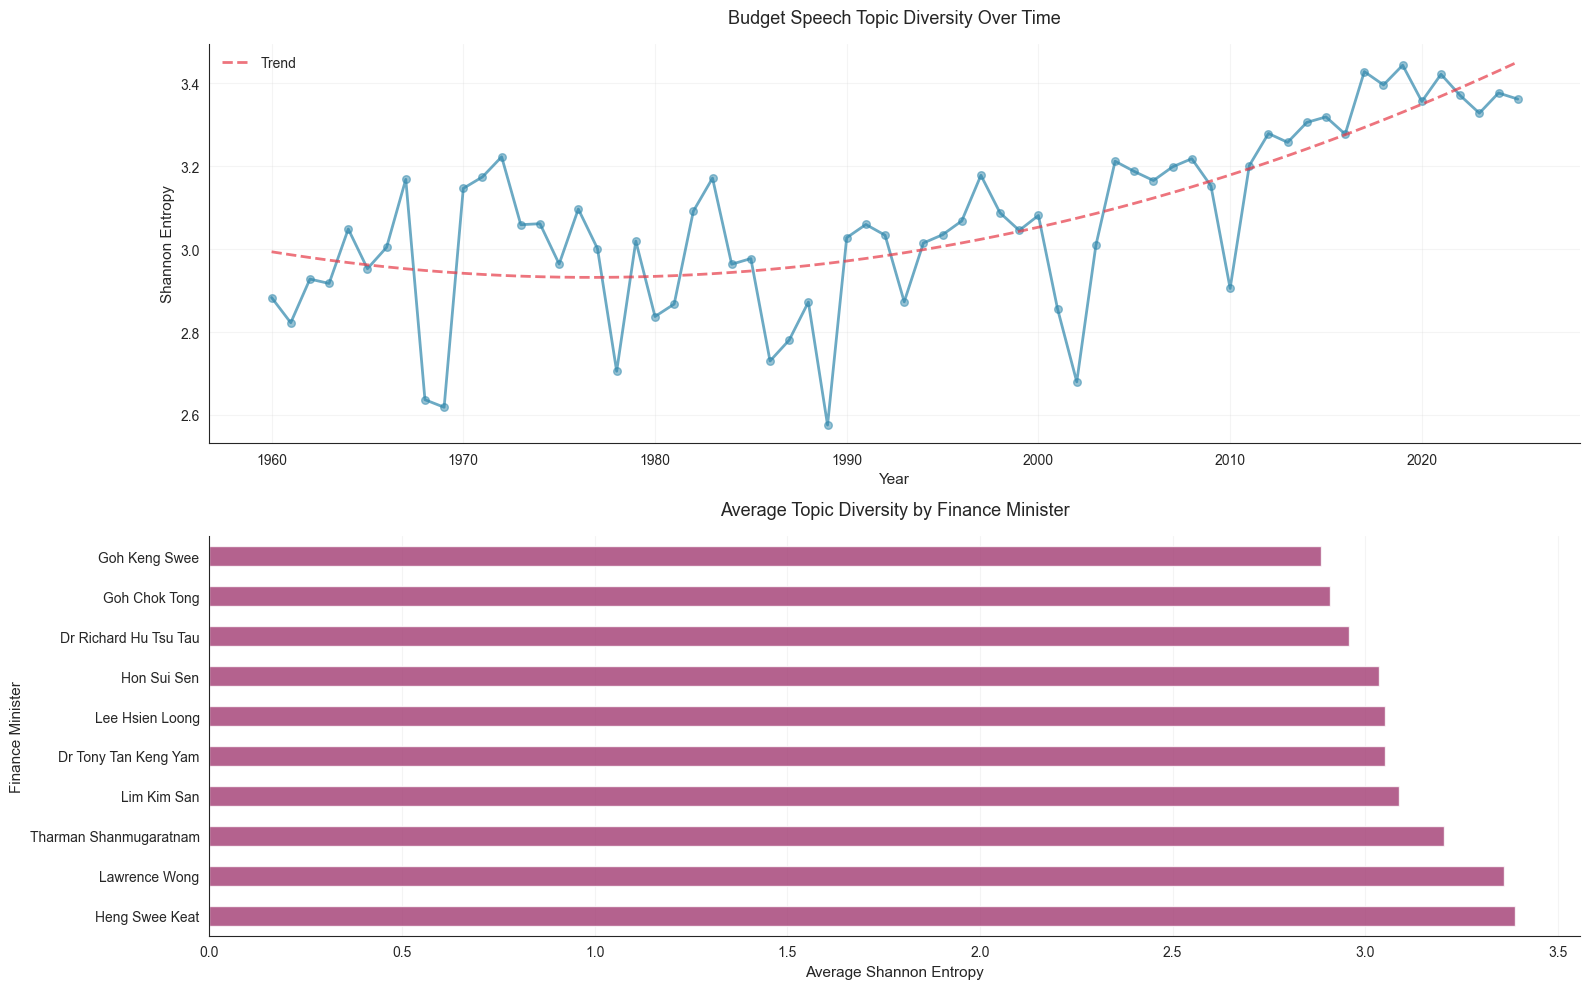


📈 TREND: Budget speeches have become MORE DIVERSE over time
   Recent speeches cover a broader range of ministry topics


In [21]:
from scipy.stats import entropy

# Calculate Shannon entropy for each year (higher = more diverse topics)
diversity_by_year = []

for year in sorted(df_all['year'].unique()):
    year_data = df_all[(df_all['year'] == year) & (df_all['ministry_topic'] != 'general')]
    
    if len(year_data) > 0:
        # Get topic distribution
        topic_counts = year_data['ministry_topic'].value_counts()
        probabilities = topic_counts / topic_counts.sum()
        
        # Calculate Shannon entropy
        H = entropy(probabilities, base=2)
        
        # Also calculate normalized entropy (0-1 scale)
        max_entropy = np.log2(len(MINISTRY_TOPICS))  # Maximum possible entropy
        normalized_H = H / max_entropy if max_entropy > 0 else 0
        
        diversity_by_year.append({
            'year': year,
            'entropy': H,
            'normalized_entropy': normalized_H,
            'minister': df_all[df_all['year'] == year]['minister'].iloc[0],
            'num_topics': len(topic_counts),
            'dominant_topic': topic_counts.idxmax(),
            'dominant_pct': topic_counts.max() / topic_counts.sum() * 100
        })

diversity_df = pd.DataFrame(diversity_by_year)

print("SPEECH DIVERSITY ANALYSIS")
print("="*100)
print("Shannon entropy measures topic diversity: higher values = more balanced coverage\n")

# Show overall statistics
print(f"Average entropy: {diversity_df['entropy'].mean():.3f}")
print(f"Average normalized entropy: {diversity_df['normalized_entropy'].mean():.3f}")
print(f"Range: {diversity_df['entropy'].min():.3f} to {diversity_df['entropy'].max():.3f}\n")

# Most and least diverse speeches
print("Most Diverse Speeches:")
print("-"*80)
for _, row in diversity_df.nlargest(5, 'entropy').iterrows():
    print(f"  {row['year']}: Entropy = {row['entropy']:.3f} | {row['minister']}")

print("\nMost Focused Speeches:")
print("-"*80)
for _, row in diversity_df.nsmallest(5, 'entropy').iterrows():
    dominant_label = MINISTRY_TOPICS[row['dominant_topic']]['label']
    print(f"  {row['year']}: Entropy = {row['entropy']:.3f} | {row['minister']}")
    print(f"           Dominated by {dominant_label} ({row['dominant_pct']:.1f}%)")

# Plot diversity over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Entropy over time
ax1.plot(diversity_df['year'], diversity_df['entropy'], 
         linewidth=2, color='#2E86AB', alpha=0.7)
ax1.scatter(diversity_df['year'], diversity_df['entropy'], 
           s=30, color='#2E86AB', alpha=0.5)

# Add trend line
z = np.polyfit(diversity_df['year'], diversity_df['entropy'], 2)
p = np.poly1d(z)
ax1.plot(diversity_df['year'], p(diversity_df['year']), 
        "--", color='#E63946', linewidth=2, alpha=0.7, label='Trend')

ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Shannon Entropy', fontsize=11)
ax1.set_title('Budget Speech Topic Diversity Over Time', fontsize=13, pad=15)
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Number of topics covered by minister
minister_diversity = diversity_df.groupby('minister').agg({
    'entropy': 'mean',
    'num_topics': 'mean'
}).sort_values('entropy', ascending=False)

minister_diversity.plot(kind='barh', y='entropy', ax=ax2, 
                        color='#A23B72', alpha=0.8, legend=False)
ax2.set_xlabel('Average Shannon Entropy', fontsize=11)
ax2.set_ylabel('Finance Minister', fontsize=11)
ax2.set_title('Average Topic Diversity by Finance Minister', fontsize=13, pad=15)
ax2.grid(True, alpha=0.2, axis='x')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Analyze trend
if diversity_df['entropy'].iloc[-10:].mean() > diversity_df['entropy'].iloc[:10].mean():
    print("\n📈 TREND: Budget speeches have become MORE DIVERSE over time")
    print("   Recent speeches cover a broader range of ministry topics")
else:
    print("\n📉 TREND: Budget speeches have become MORE FOCUSED over time")
    print("   Recent speeches concentrate on fewer ministry topics")

## Summary Statistics by Ministry Topic

In [ ]:
# Calculate comprehensive statistics for each ministry
summary_stats = []

for ministry in sorted([m for m in MINISTRY_TOPICS.keys()]):
    ministry_data = df_all[df_all['ministry_topic'] == ministry]
    
    if len(ministry_data) > 0:
        stats = {
            'Ministry': MINISTRY_TOPICS[ministry]['label'],
            'Total Sentences': len(ministry_data),
            '% of Total': (len(ministry_data) / len(df_all)) * 100,
            'Avg Confidence': ministry_data['topic_confidence'].mean(),
            'Years Mentioned': ministry_data['year'].nunique(),
            'First Mention': ministry_data['year'].min(),
            'Last Mention': ministry_data['year'].max(),
            'Peak Year': ministry_data.groupby('year').size().idxmax(),
            'Peak Year Count': ministry_data.groupby('year').size().max(),
        }
        summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.sort_values('Total Sentences', ascending=False)

print("\nMinistry Topic Summary Statistics:")
print("="*120)
print(summary_df.to_string(index=False))

# Export to CSV
output_file = Path.cwd() / 'ministry_topic_statistics.csv'
summary_df.to_csv(output_file, index=False)
print(f"\n✓ Summary statistics saved to: {output_file.name}")

## Export Classified Data

Save the sentence-level data with ministry topic classifications for further analysis.

In [ ]:
# Save ministry-year distribution
ministry_year_file = Path.cwd() / 'ministry_by_year.csv'
ministry_pct.to_csv(ministry_year_file)
print(f"✓ Ministry-year distribution saved to: {ministry_year_file.name}")

# Save ministry-minister distribution
minister_ministry_file = Path.cwd() / 'ministry_by_minister.csv'
minister_ministry_pct.to_csv(minister_ministry_file)
print(f"✓ Ministry-minister distribution saved to: {minister_ministry_file.name}")

# Save ministry-decade distribution
decade_file = Path.cwd() / 'ministry_by_decade.csv'
ministry_by_decade_pct.to_csv(decade_file)
print(f"✓ Ministry-decade distribution saved to: {decade_file.name}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE! 🎉")
print("="*80)
print("\nKey findings:")
print(f"  • Analyzed {len(df_all):,} sentences across {df_all['year'].nunique()} years")
print(f"  • Classified into {len(MINISTRY_TOPICS)} ministry topics")
print(f"  • {(df_all['ministry_topic'] != 'general').sum():,} sentences ({(df_all['ministry_topic'] != 'general').sum() / len(df_all) * 100:.1f}%) matched to specific ministries")
print(f"  • Generated 6 comprehensive visualizations")
print(f"  • Exported 4 CSV files for further analysis")